 **High-Frequency (Crypto price) trading rules using Machine Learning**
 
 Version 2.0 (Technical Indicators(market data))
 
 Momentum strategy + Meta-Labeling



# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Getting Signals (Long position only)
 - Momentum strategy (RSI)


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with the signals
 - Binary Labeling (Profit or Loss)


4. Prediction Model

 4.1. Get Features (X)
 - Market data & Technical Analysis
 - *Market Microstructure Features
 - *Macroeconomic Variables
 - *Fundamentals
 - *News Sentiments with NLP
 
 4.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ NL Autoencoder)
 
 4.2. Machine Learning Model
 - Hyperparameter tuning
 - AutoML with *autogluon* and select the best model
 - *Feature Importance
 - Results with PnL
 
 
5. Trading
 - *Bet Sizing
 - *Trading Simulation
 
 
5. Results
 - *Cumulative returns, Sharpe Ratio, Drawdown


In [1]:
# https://www.aidoczh.com/autogluon/install.html
# 安装基础数据科学包
# mamba install -y pandas jupyter ipykernel matplotlib scikit-learn -c conda-forge

# # 使用 pip 安装 macOS 专用的 tensorflow
# pip install tensorflow-macos tensorflow-metal

# python -m pip install tensorflow-macos tensorflow-metal "numpy<2.0" ipykernel matplotlib pandas keras scikit-learn seaborn autogluon ta ta-lib


In [2]:
import numpy
import tensorflow as tf

print(f"Numpy version: {numpy.__version__}")
# 应该显示 1.26.x 或类似版本，绝对不能是 2.x.x

print(f"TensorFlow version: {tf.__version__}")
# 现在应该可以正常输出了

import autogluon as ag




Numpy version: 1.26.4
TensorFlow version: 2.16.2


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from features import triple_barrier as tb, getTA, tautil
import autogluon as ag

from sklearn import preprocessing
from sklearn.decomposition import PCA 
from features import triple_barrier as tb, getTA, tautil

from scipy.stats import norm, moment

import keras


In [4]:
# De Prado AMFL

# from scipy.stats import norm, moment

# #feature
# from sklearn import preprocessing
# from sklearn.decomposition import PCA 

# #ML
# import autogluon as ag

# deep learning
# import keras

# Technical analysis
# import ta

# Backtesting pyfolio
#import pyfolio as pf


In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# Financial Data and Bars

## OHLCV Bar + Buy Volume

- Asset: ETH/USD 
- 5 minute data

In [7]:
# df_raw = pd.read_csv('ethusd5min.csv')
# df = df_raw.set_index('timestamp')
# df.index = pd.to_datetime(df.index)

from dataload import data_load_v2

sym = 'ETHUSDT'
data_dir = '/Users/aming/data/ETHUSDT/15m'
start_date_train = '2025-01-01'
end_date_train = '2025-06-01'
start_date_test = '2025-06-01'
end_date_test = '2025-08-01'
timeframe =  '15m'


df = data_load_v2(sym, data_dir=data_dir, start_date=start_date_train, end_date=end_date_test,
                        timeframe=timeframe, file_path=None)

column_mapping = {
    'o':'open',
    'h':'high',
    'l':'low',
    'c':'close',
    'vol':'volume',
    'vol_ccy':'quote_av',
    'trades':'count',
    'close_time':'close_time',
    'taker_buy_volume':'tb_base_av',
    'taker_buy_quote_volume':'tb_quote_av'

}
df = df.rename(columns=column_mapping)



✓ 成功读取 feather: ETHUSDT-15m-2025-01.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-02.feather, 行数: 2688
✓ 成功读取 feather: ETHUSDT-15m-2025-03.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-04.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2025-05.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-06.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2025-07.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-08.feather, 行数: 2976

读取完成: 成功 8 个，失败 0 个

合并后总行数: 23,328
数据时间范围: 2025-01-01 00:00:00 至 2025-08-31 23:45:00



In [8]:
df

open     high      low    close      volume  \
open_time                                                             
2025-01-01 00:00:00  3336.58  3348.47  3334.76  3347.40   11849.907   
2025-01-01 00:15:00  3347.41  3353.00  3345.99  3348.62   13400.864   
2025-01-01 00:30:00  3348.63  3360.47  3348.03  3355.36   28098.106   
2025-01-01 00:45:00  3355.36  3364.50  3353.11  3362.90   14978.352   
2025-01-01 01:00:00  3362.89  3365.32  3354.00  3359.62   13083.658   
...                      ...      ...      ...      ...         ...   
2025-08-31 22:45:00  4439.88  4443.99  4431.24  4442.72   54551.758   
2025-08-31 23:00:00  4442.72  4442.73  4421.00  4432.11   53216.142   
2025-08-31 23:15:00  4432.11  4432.12  4400.00  4405.76  117895.730   
2025-08-31 23:30:00  4405.77  4405.77  4374.66  4384.88  111288.986   
2025-08-31 23:45:00  4384.88  4392.42  4380.00  4389.58   40480.906   

                         quote_av   count     close_time  tb_base_av  \
open_time                                                              
2025-01-01 00:00:00  3.959481e+07   30079  1735690499999    7513.408   
2025-01-01 00:15:00  4.488825e+07   30217  1735691399999    7352.137   
2025-01-01 00:30:00  9.427517e+07   36044  1735692299999   17922.882   
2025-01-01 00:45:00  5.032034e+07   31919  1735693199999    9098.811   
2025-01-01 01:00:00  4.395107e+07   28529  1735694099999    5268.456   
...                           ...     ...            ...         ...   
2025-08-31 22:45:00  2.420542e+08   57094  1756681199999   25257.950   
2025-08-31 23:00:00  2.357419e+08   58917  1756682099999   21558.375   
2025-08-31 23:15:00  5.202155e+08  108472  1756682999999   40165.991   
2025-08-31 23:30:00  4.884217e+08  124552  1756683899999   50124.026   
2025-08-31 23:45:00  1.776020e+08   56557  1756684799999   24583.712   

                      tb_quote_av  
open_time                          
2025-01-01 00:00:00  2.510607e+07  
2025-01-01 00:15:00  2.462981e+07  
2025-01-01 00:30:00  6.013062e+07  
2025-01-01 00:45:00  3.056924e+07  
2025-01-01 01:00:00  1.769978e+07  
...                           ...  
2025-08-31 22:45:00  1.120878e+08  
2025-08-31 23:00:00  9.551774e+07  
2025-08-31 23:15:00  1.772652e+08  
2025-08-31 23:30:00  2.199964e+08  
2025-08-31 23:45:00  1.078631e+08  

[23328 rows x 10 columns]

In [9]:
# df

<Axes: xlabel='open_time'>

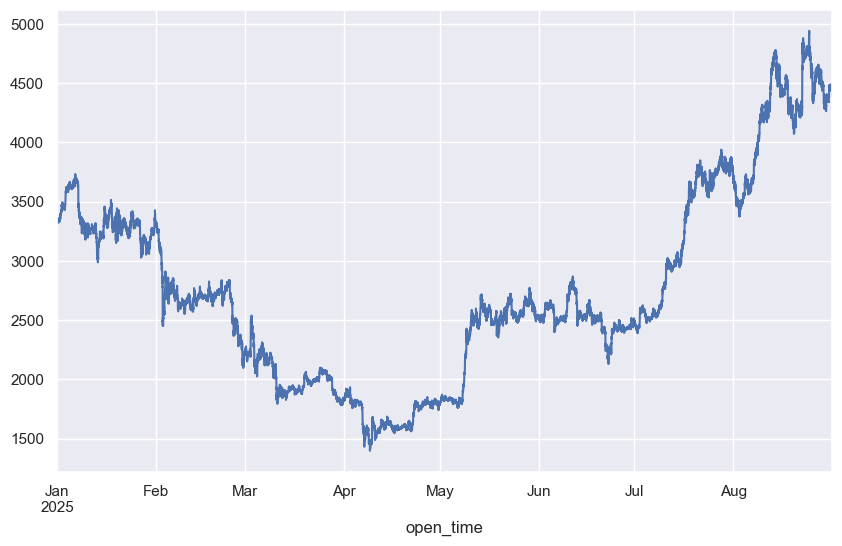

In [10]:
df.close.plot(figsize=(10,6))

In [11]:
# after 2021, there's huge updowns.
# df = df.loc[:'2020-12':,:]

In [12]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [13]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ohlcv.describe()

open          high           low         close        volume
count  23328.000000  23328.000000  23328.000000  23328.000000  2.332800e+04
mean    2761.451602   2768.838296   2753.798063   2761.497482  5.753160e+04
std      816.786626    818.705864    814.774116    816.847518  6.906572e+04
min     1396.800000   1422.190000   1384.000000   1396.810000  2.703858e+03
25%     2106.017500   2118.985000   2095.330000   2106.020000  2.155887e+04
50%     2593.610000   2600.295000   2585.560000   2593.605000  3.687754e+04
75%     3315.022500   3323.560000   3305.782500   3315.030000  6.700337e+04
max     4941.090000   4957.670000   4932.400000   4941.080000  1.345471e+06

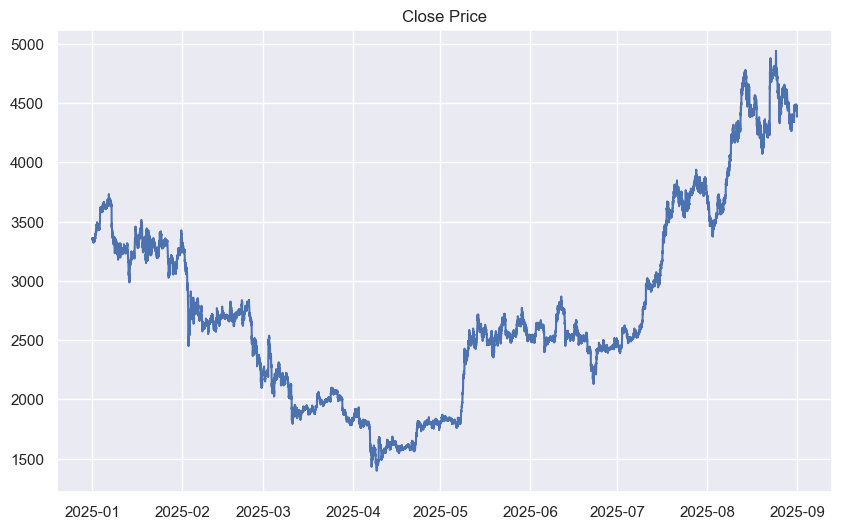

In [14]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

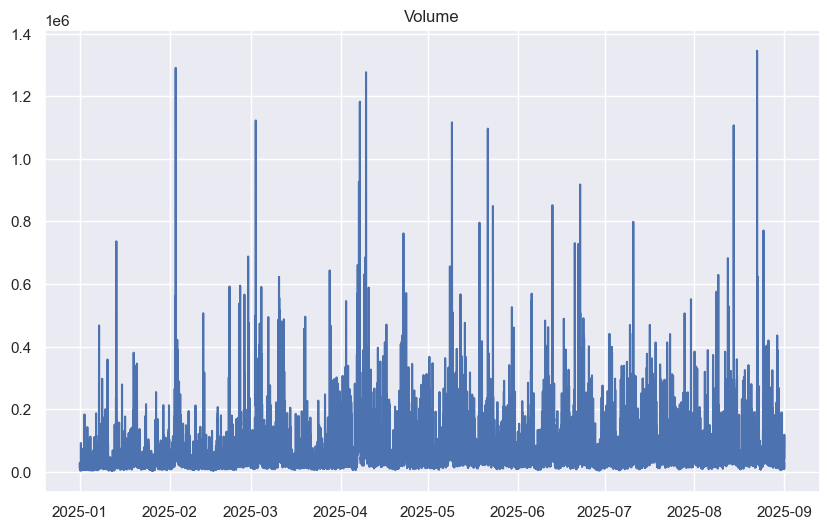

In [15]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [16]:
of = buy_volume - (volume-buy_volume)

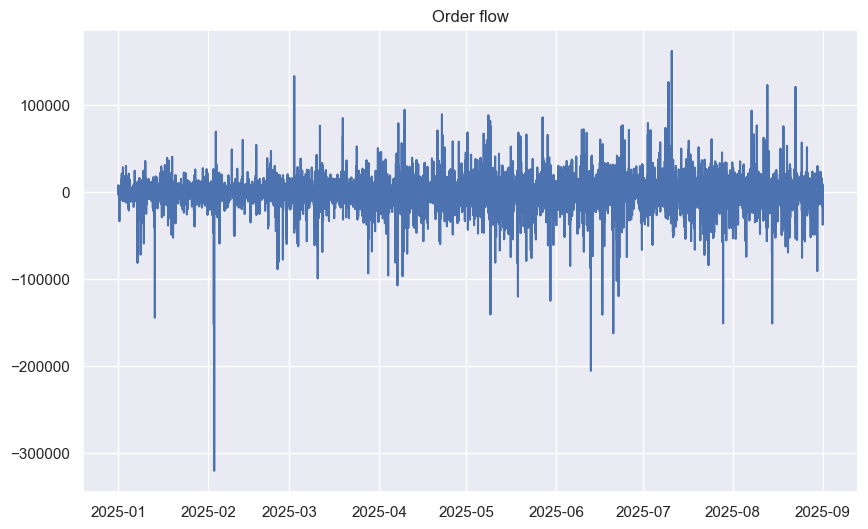

In [17]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

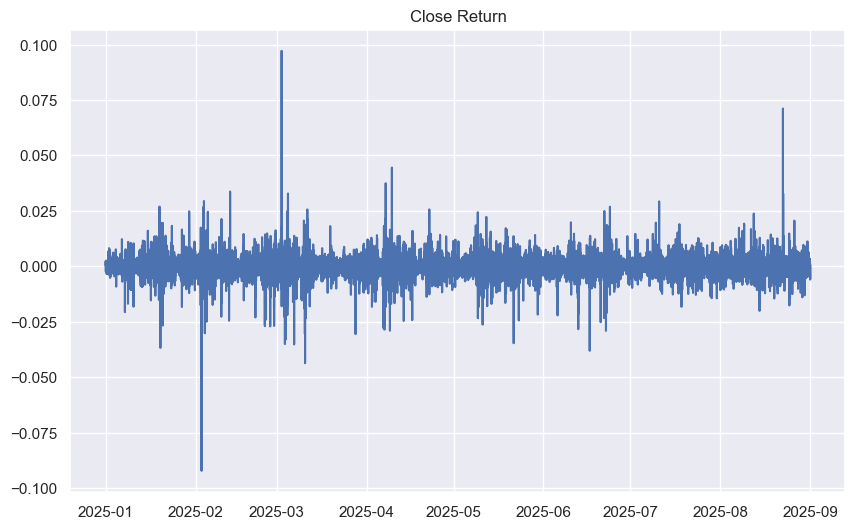

In [18]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

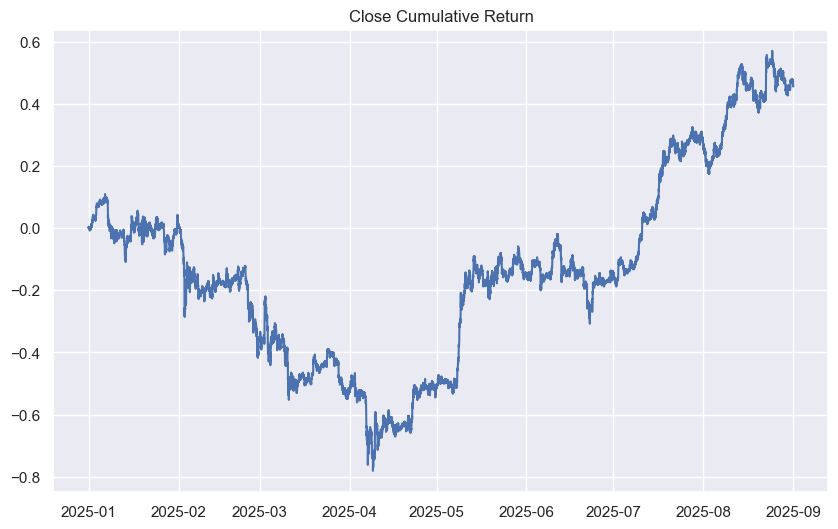

In [19]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# Getting Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

## Momentum strategy

In [20]:
windows = np.arange(10,210,10)

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [21]:
rsi_df = pd.DataFrame(index=df.index)

In [22]:
# for w in windows:
#     rsi_df['rsi_{}'.format(w)] = tautil.get_rsi(close, w)
rsi_df = tautil.get_my_rsi(close, windows)
rsi_df.dropna(inplace=True)

rsi_df

rsi_10  rsi_20  rsi_30  rsi_40  rsi_50  rsi_60  rsi_70  \
open_time                                                                     
2025-01-03 02:00:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2025-01-03 02:15:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2025-01-03 02:30:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-01-03 02:45:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-01-03 03:00:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-08-31 22:45:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2025-08-31 23:00:00    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-08-31 23:15:00     1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-08-31 23:30:00     1.0     1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2025-08-31 23:45:00     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

                     rsi_80  rsi_90  rsi_100  rsi_110  rsi_120  rsi_130  \
open_time                                                                 
2025-01-03 02:00:00     1.0     1.0      1.0      1.0      1.0      1.0   
2025-01-03 02:15:00     1.0     1.0      1.0      1.0      1.0      1.0   
2025-01-03 02:30:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-01-03 02:45:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-01-03 03:00:00     1.0     1.0      1.0      1.0      1.0      1.0   
...                     ...     ...      ...      ...      ...      ...   
2025-08-31 22:45:00     1.0     1.0      1.0      1.0      1.0      1.0   
2025-08-31 23:00:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:15:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:30:00    -1.0    -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:45:00     1.0     1.0      1.0      1.0      1.0      1.0   

                     rsi_140  rsi_150  rsi_160  rsi_170  rsi_180  rsi_190  \
open_time                                                                   
2025-01-03 02:00:00      1.0      1.0      1.0      1.0      1.0      1.0   
2025-01-03 02:15:00      1.0      1.0      1.0      1.0      1.0      1.0   
2025-01-03 02:30:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-01-03 02:45:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-01-03 03:00:00      1.0      1.0      1.0      1.0      1.0      1.0   
...                      ...      ...      ...      ...      ...      ...   
2025-08-31 22:45:00      1.0      1.0      1.0      1.0      1.0      1.0   
2025-08-31 23:00:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:15:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:30:00     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
2025-08-31 23:45:00      1.0      1.0      1.0      1.0      1.0      1.0   

                     rsi_200  
open_time                     
2025-01-03 02:00:00      1.0  
2025-01-03 02:15:00      1.0  
2025-01-03 02:30:00     -1.0  
2025-01-03 02:45:00     -1.0  
2025-01-03 03:00:00      1.0  
...                      ...  
2025-08-31 22:45:00      1.0  
2025-08-31 23:00:00     -1.0  
2025-08-31 23:15:00     -1.0  
2025-08-31 23:30:00     -1.0  
2025-08-31 23:45:00      1.0  

[23128 rows x 20 columns]

rsi(14) is often adopted in daily data.

Here is 5 minutes data.

And we have to consider this is crypto data which is far more volatile.


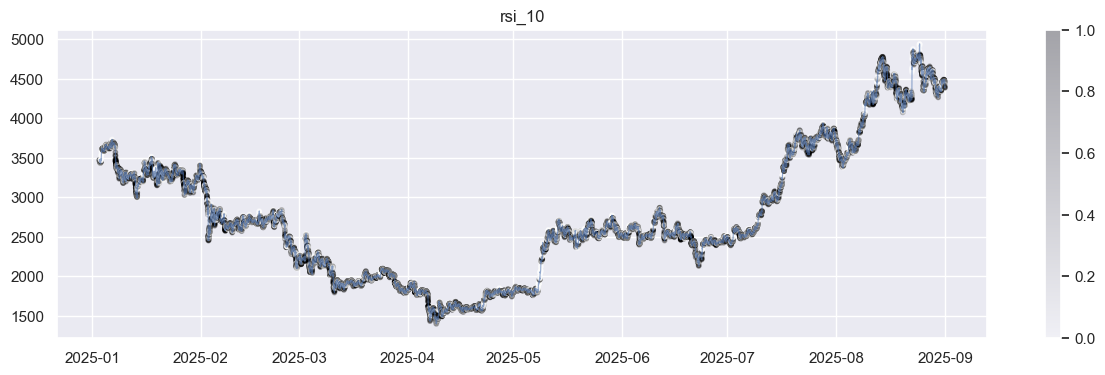

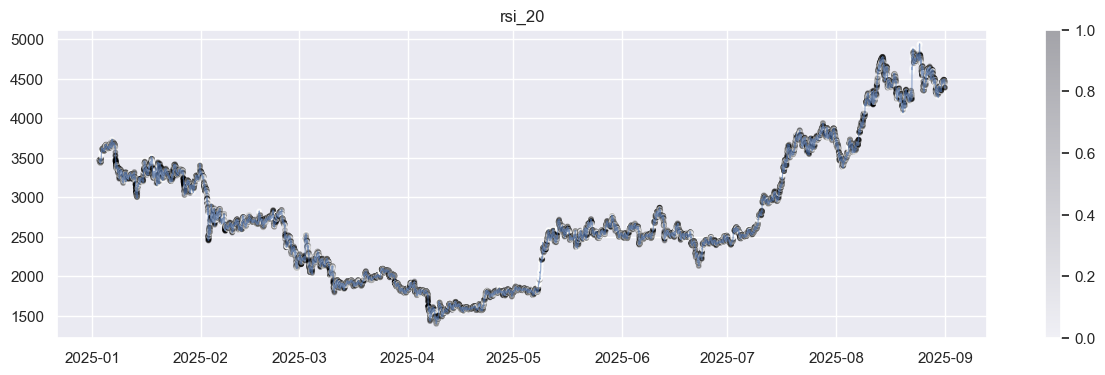

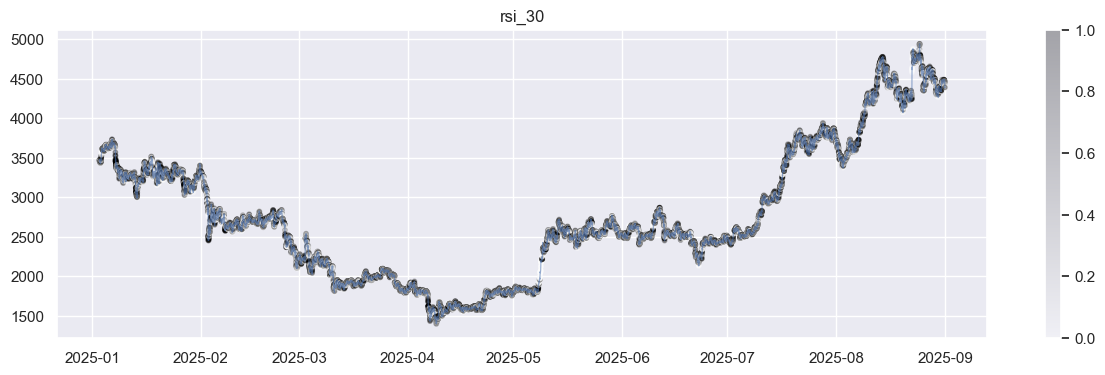

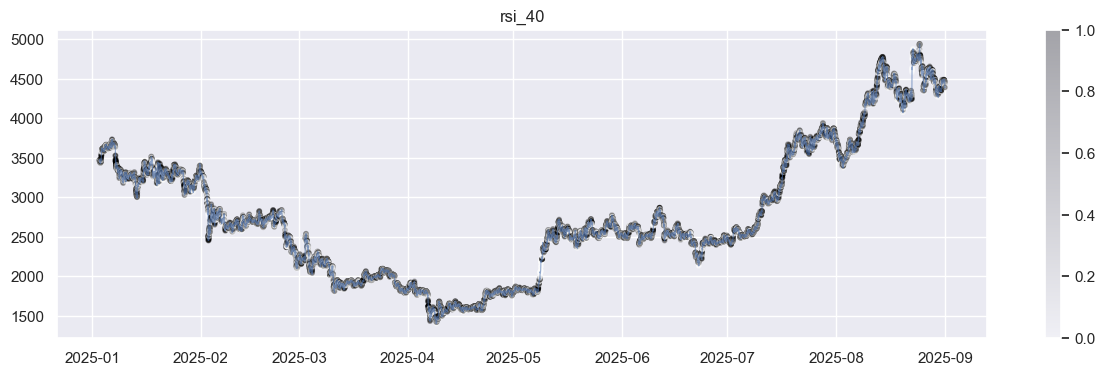

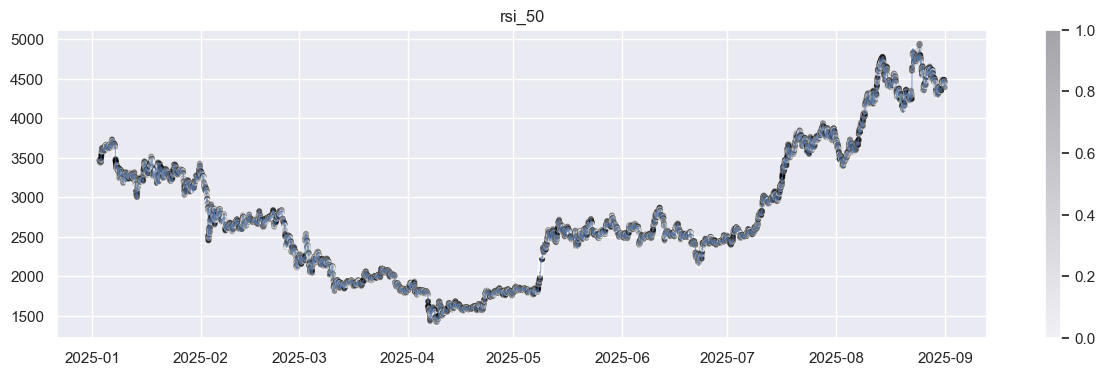

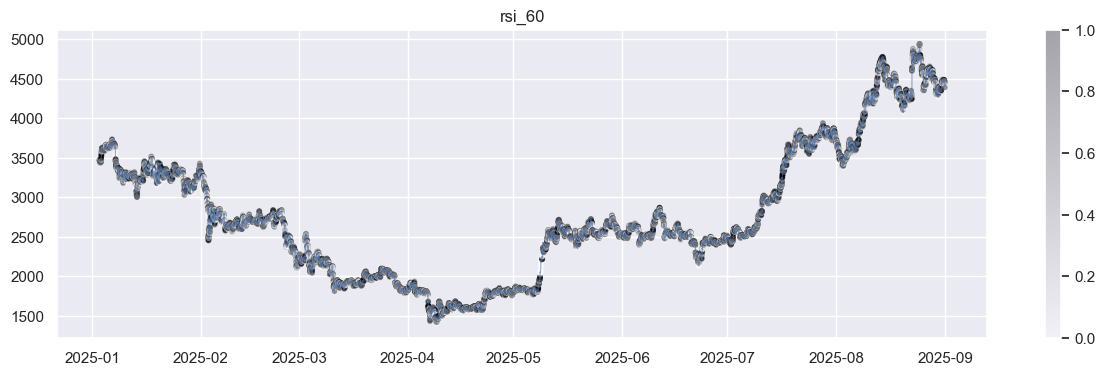

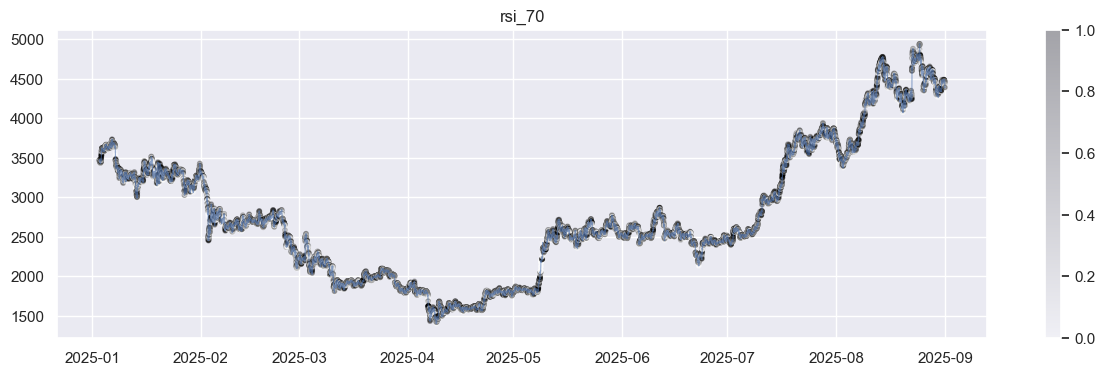

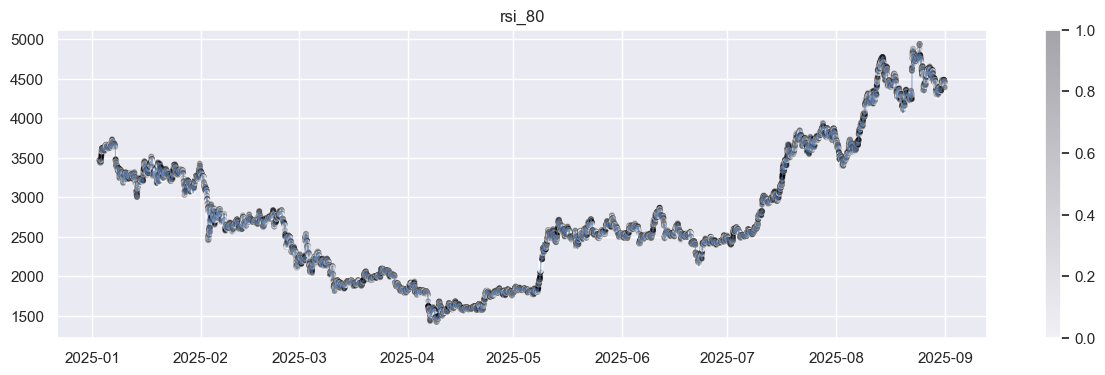

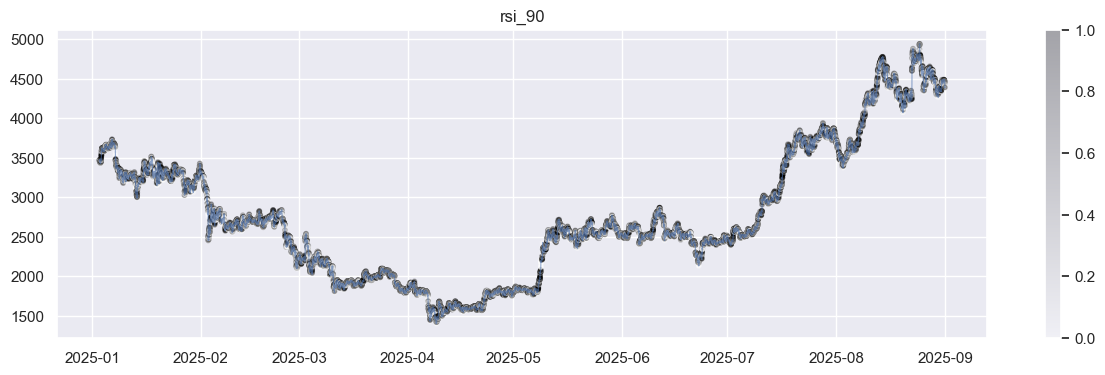

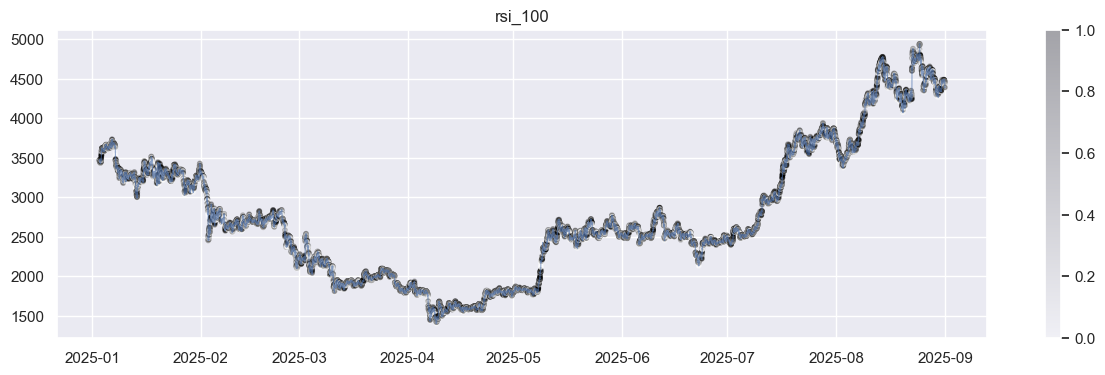

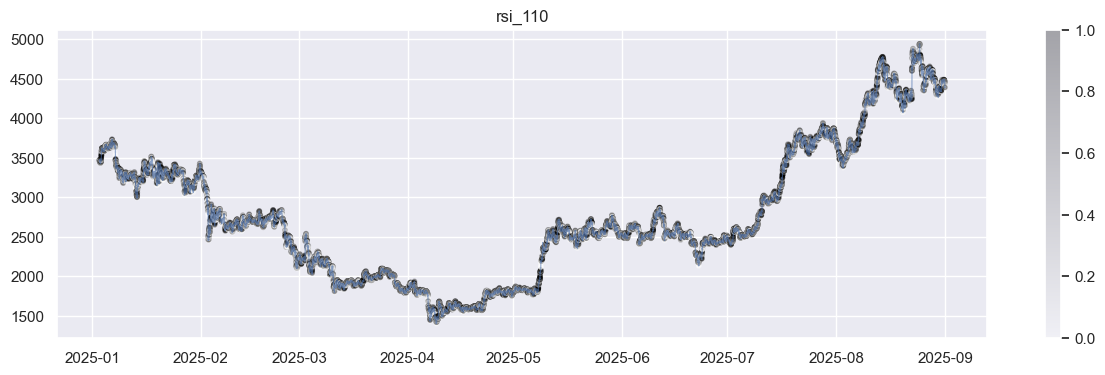

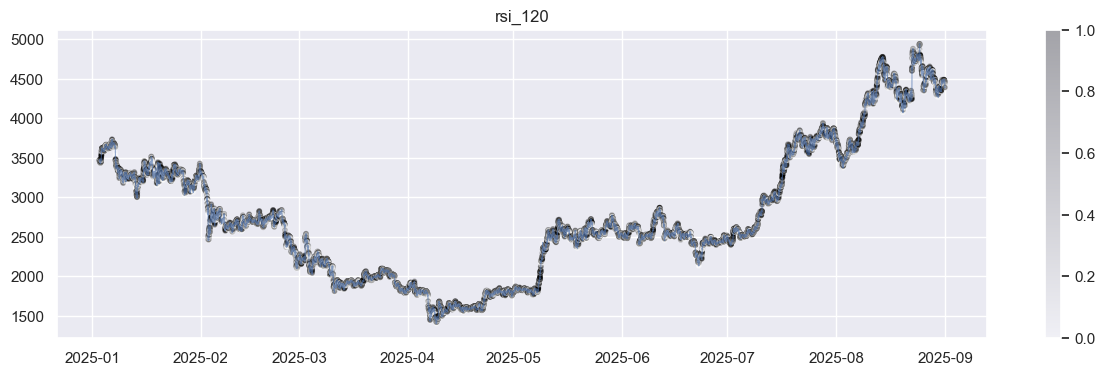

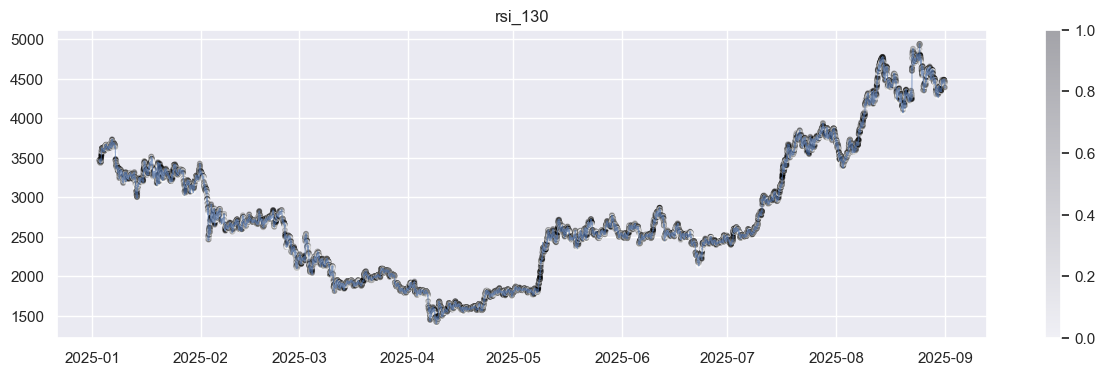

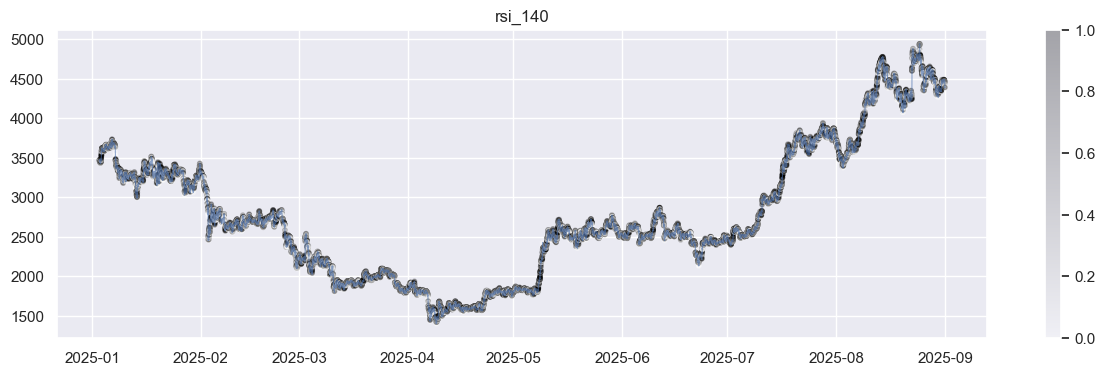

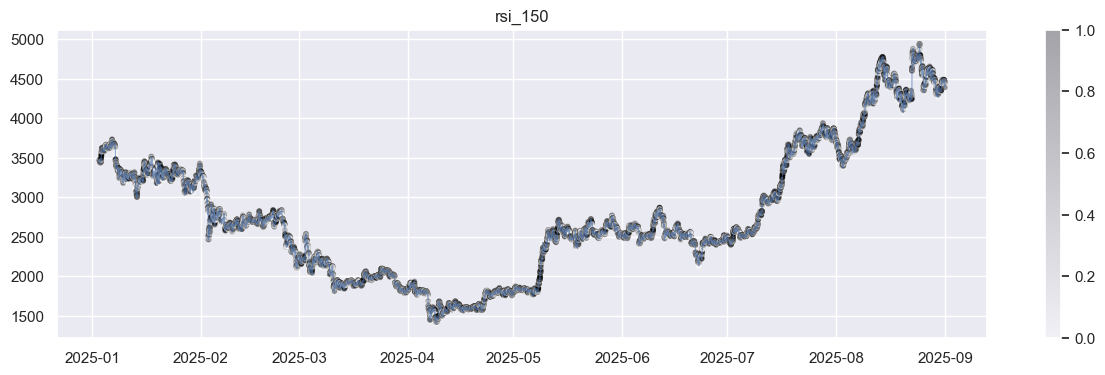

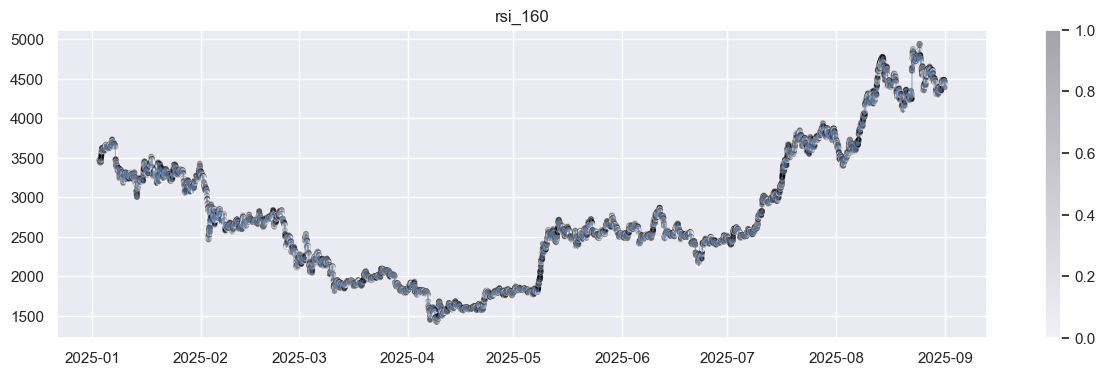

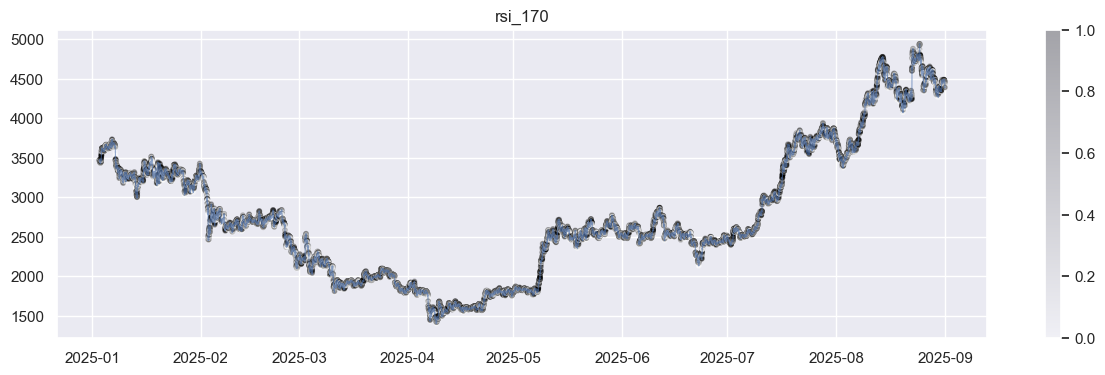

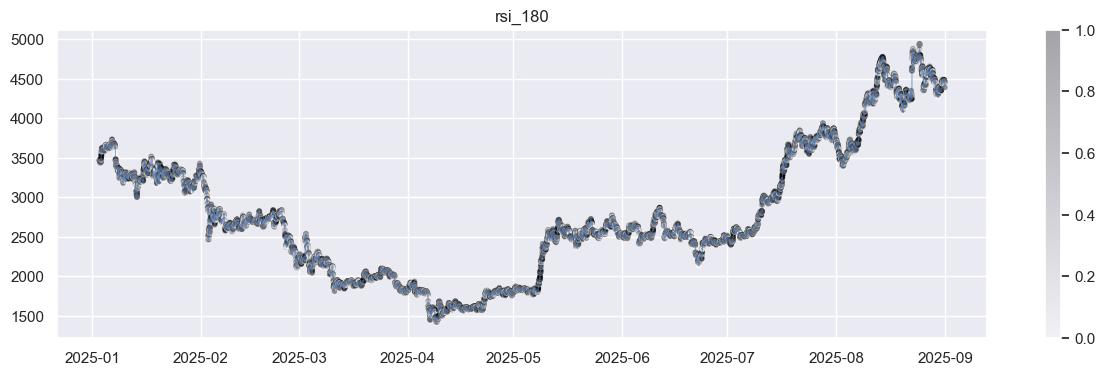

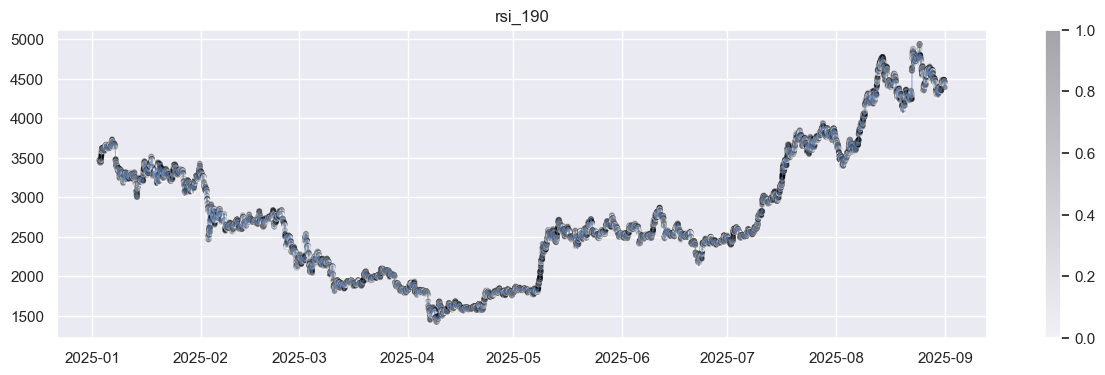

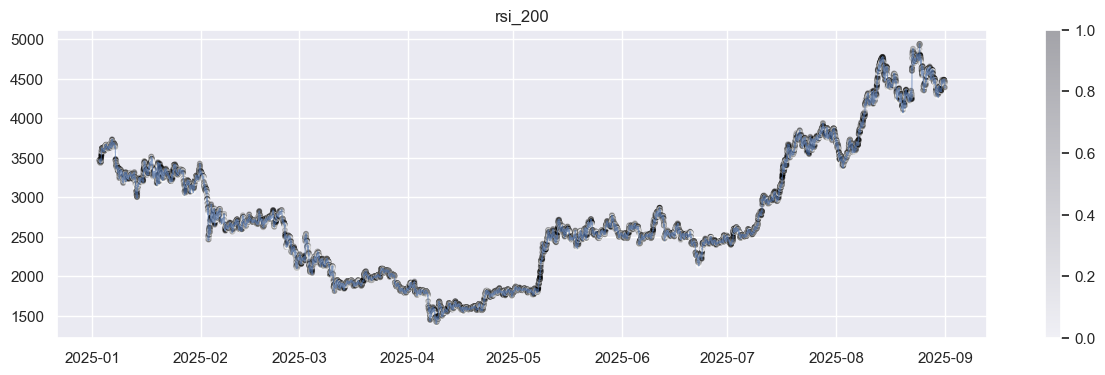

In [23]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(15,4))
    plt.plot(close.loc[sc.index], linewidth=0.8,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', s = 10, alpha=0.3, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

# Labeling with Triple-Barrier Method
 ## Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [24]:
# returns_df = pd.DataFrame()

# for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [25]:
# for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [26]:
#returns_df.cumsum()

For simplicity, I will choose rsi window = 100 for this asset and interval.

You can use other methods, for example combining with MACD.


In [27]:
rsi_w = 'rsi_100'

# rsi_df[rsi_df[rsi_w]!=1]
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.05,0.05] # profit-taking, stop-loss target
max_holding = [14,0] #[day,hours]
enter

barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
barrier

exit    price       ret  side
open_time                                                       
2025-01-03 02:00:00 2025-01-04 13:00:00  3469.31  0.048898   1.0
2025-01-03 02:15:00 2025-01-04 20:30:00  3473.81  0.052318   1.0
2025-01-03 03:00:00 2025-01-04 12:15:00  3456.66  0.050372   1.0
2025-01-03 03:15:00 2025-01-04 12:15:00  3458.70  0.049782   1.0
2025-01-03 03:30:00 2025-01-04 13:00:00  3464.51  0.050283   1.0
...                                 ...      ...       ...   ...
2025-08-31 21:00:00                 NaT  4463.64  0.000000   1.0
2025-08-31 21:30:00                 NaT  4473.90  0.000000   1.0
2025-08-31 22:15:00                 NaT  4465.83  0.000000   1.0
2025-08-31 22:45:00                 NaT  4442.72  0.000000   1.0
2025-08-31 23:45:00                 NaT  4389.58  0.000000   1.0

[11748 rows x 4 columns]

Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

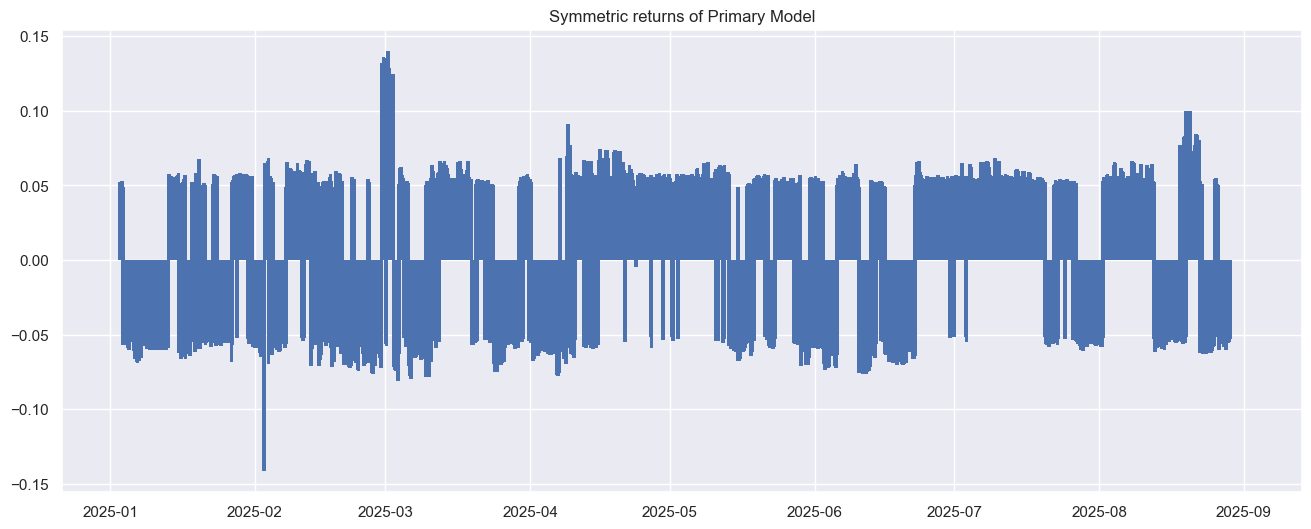

In [28]:
ret = barrier.ret
plt.figure(figsize=(16,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

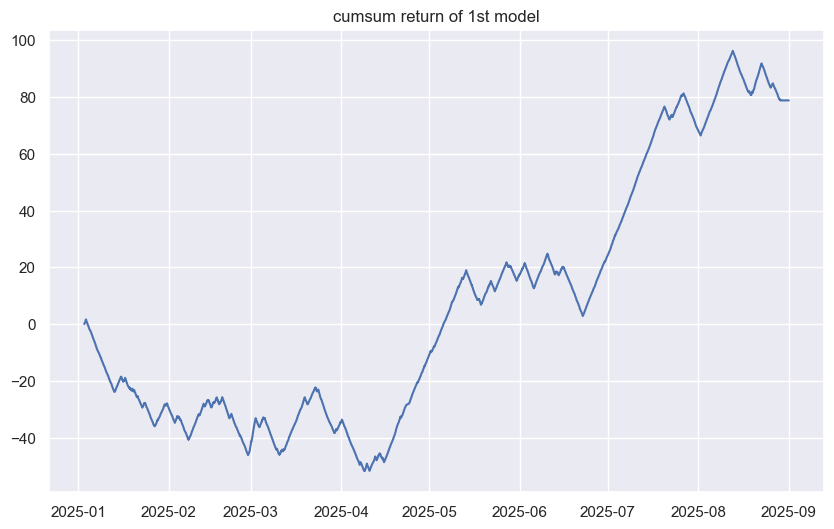

In [29]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

## Binary Labeling (Profit or Loss)

In [30]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

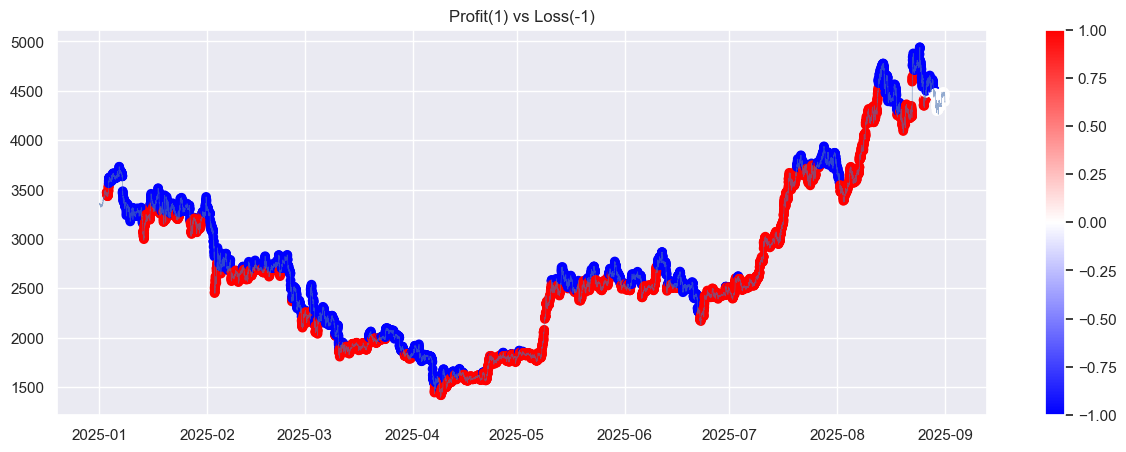

In [31]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [32]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

y_true
 1.0    6630
-1.0    4964
Name: count, dtype: int64

In [33]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.5718475073313783


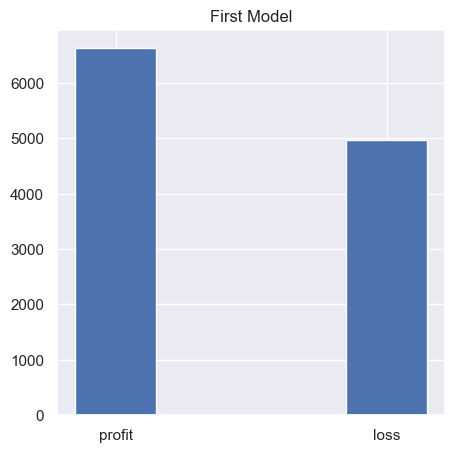

In [34]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

# Prediction Model

For feature engineering we have to split train and test periods.

In [35]:
y = pnllabel.copy().rename('y').to_frame()
train_y = y.loc[:end_date_train,:]
test_y = y.loc[start_date_test:,:]
y
train_y

y
open_time               
2025-01-03 02:00:00  1.0
2025-01-03 02:15:00  1.0
2025-01-03 03:00:00  1.0
2025-01-03 03:15:00  1.0
2025-01-03 03:30:00  1.0
...                  ...
2025-06-01 21:45:00  1.0
2025-06-01 22:00:00 -1.0
2025-06-01 22:30:00  1.0
2025-06-01 23:00:00  1.0
2025-06-01 23:45:00  1.0

[7247 rows x 1 columns]

 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [36]:
df_ = df_ohlcv

In [37]:
mts= [5,10,30,60,100] #multipliers
TA = getTA.get_ta_windows(df_,mts)

In [38]:
TA

aroon_125  aroon_1500  aroon_250  aroon_2500  aroon_750  \
open_time                                                                      
2025-01-01 00:00:00        NaN         NaN        NaN         NaN        NaN   
2025-01-01 00:15:00        NaN         NaN        NaN         NaN        NaN   
2025-01-01 00:30:00        NaN         NaN        NaN         NaN        NaN   
2025-01-01 00:45:00        NaN         NaN        NaN         NaN        NaN   
2025-01-01 01:00:00        NaN         NaN        NaN         NaN        NaN   
...                        ...         ...        ...         ...        ...   
2025-08-31 22:45:00       52.0   30.066667       55.6       72.36 -68.133333   
2025-08-31 23:00:00       52.0   30.066667       55.6       72.36 -68.133333   
2025-08-31 23:15:00       52.0   30.066667       55.6       71.80 -68.133333   
2025-08-31 23:30:00       52.0   30.066667       55.6       71.80 -68.133333   
2025-08-31 23:45:00       52.0   30.066667       55.6       71.80 -68.133333   

                     dpo_100    dpo_1200   dpo_200    dpo_2000    dpo_600  \
open_time                                                                   
2025-01-01 00:00:00      NaN         NaN       NaN         NaN        NaN   
2025-01-01 00:15:00      NaN         NaN       NaN         NaN        NaN   
2025-01-01 00:30:00      NaN         NaN       NaN         NaN        NaN   
2025-01-01 00:45:00      NaN         NaN       NaN         NaN        NaN   
2025-01-01 01:00:00      NaN         NaN       NaN         NaN        NaN   
...                      ...         ...       ...         ...        ...   
2025-08-31 22:45:00  -1.7824  140.030908 -62.96495 -204.020675 -10.837100   
2025-08-31 23:00:00   3.5659  113.214983 -61.78325 -225.256555 -30.068933   
2025-08-31 23:15:00  -2.7722  100.360325 -67.16220 -213.744440  -8.130983   
2025-08-31 23:30:00  -0.6009  109.805933 -56.20550 -201.541715  -5.700067   
2025-08-31 23:45:00 -10.7847   96.637367 -51.27735 -186.232620  -1.893983   

                     ...    rsi_140   rsi_1400    rsi_420     rsi_70  \
open_time            ...                                               
2025-01-01 00:00:00  ...        NaN        NaN        NaN        NaN   
2025-01-01 00:15:00  ...        NaN        NaN        NaN        NaN   
2025-01-01 00:30:00  ...        NaN        NaN        NaN        NaN   
2025-01-01 00:45:00  ...        NaN        NaN        NaN        NaN   
2025-01-01 01:00:00  ...        NaN        NaN        NaN        NaN   
...                  ...        ...        ...        ...        ...   
2025-08-31 22:45:00  ...  50.273188  50.583010  49.713597  50.370385   
2025-08-31 23:00:00  ...  49.833601  50.547974  49.596055  49.372119   
2025-08-31 23:15:00  ...  48.766974  50.461110  49.305842  47.024078   
2025-08-31 23:30:00  ...  47.947900  50.392440  49.077734  45.292473   
2025-08-31 23:45:00  ...  48.145354  50.407642  49.130834  45.748673   

                       rsi_840  stoch_diff_1400_3  stoch_diff_140_3  \
open_time                                                             
2025-01-01 00:00:00        NaN                NaN               NaN   
2025-01-01 00:15:00        NaN                NaN               NaN   
2025-01-01 00:30:00        NaN                NaN               NaN   
2025-01-01 00:45:00        NaN                NaN               NaN   
2025-01-01 01:00:00        NaN                NaN               NaN   
...                        ...                ...               ...   
2025-08-31 22:45:00  50.159714          -0.753061         -4.010679   
2025-08-31 23:00:00  50.103149          -0.682879         -3.636903   
2025-08-31 23:15:00  49.963053          -2.350901        -12.520518   
2025-08-31 23:30:00  49.852464          -2.529140        -13.469791   
2025-08-31 23:45:00  49.877466          -0.426289         -2.270345   

                     stoch_diff_420_3  stoch_diff_70_3  stoch_diff_840_3  
open_time                                 

First I chose default windows (daily) for each technical indicators/

This is 5 minute data and in first model, I chose rsi_100 instead of rsi_14.

So I will muliply some numbers to the windows. [10,30,50,100]

In [39]:
mkt = TA.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

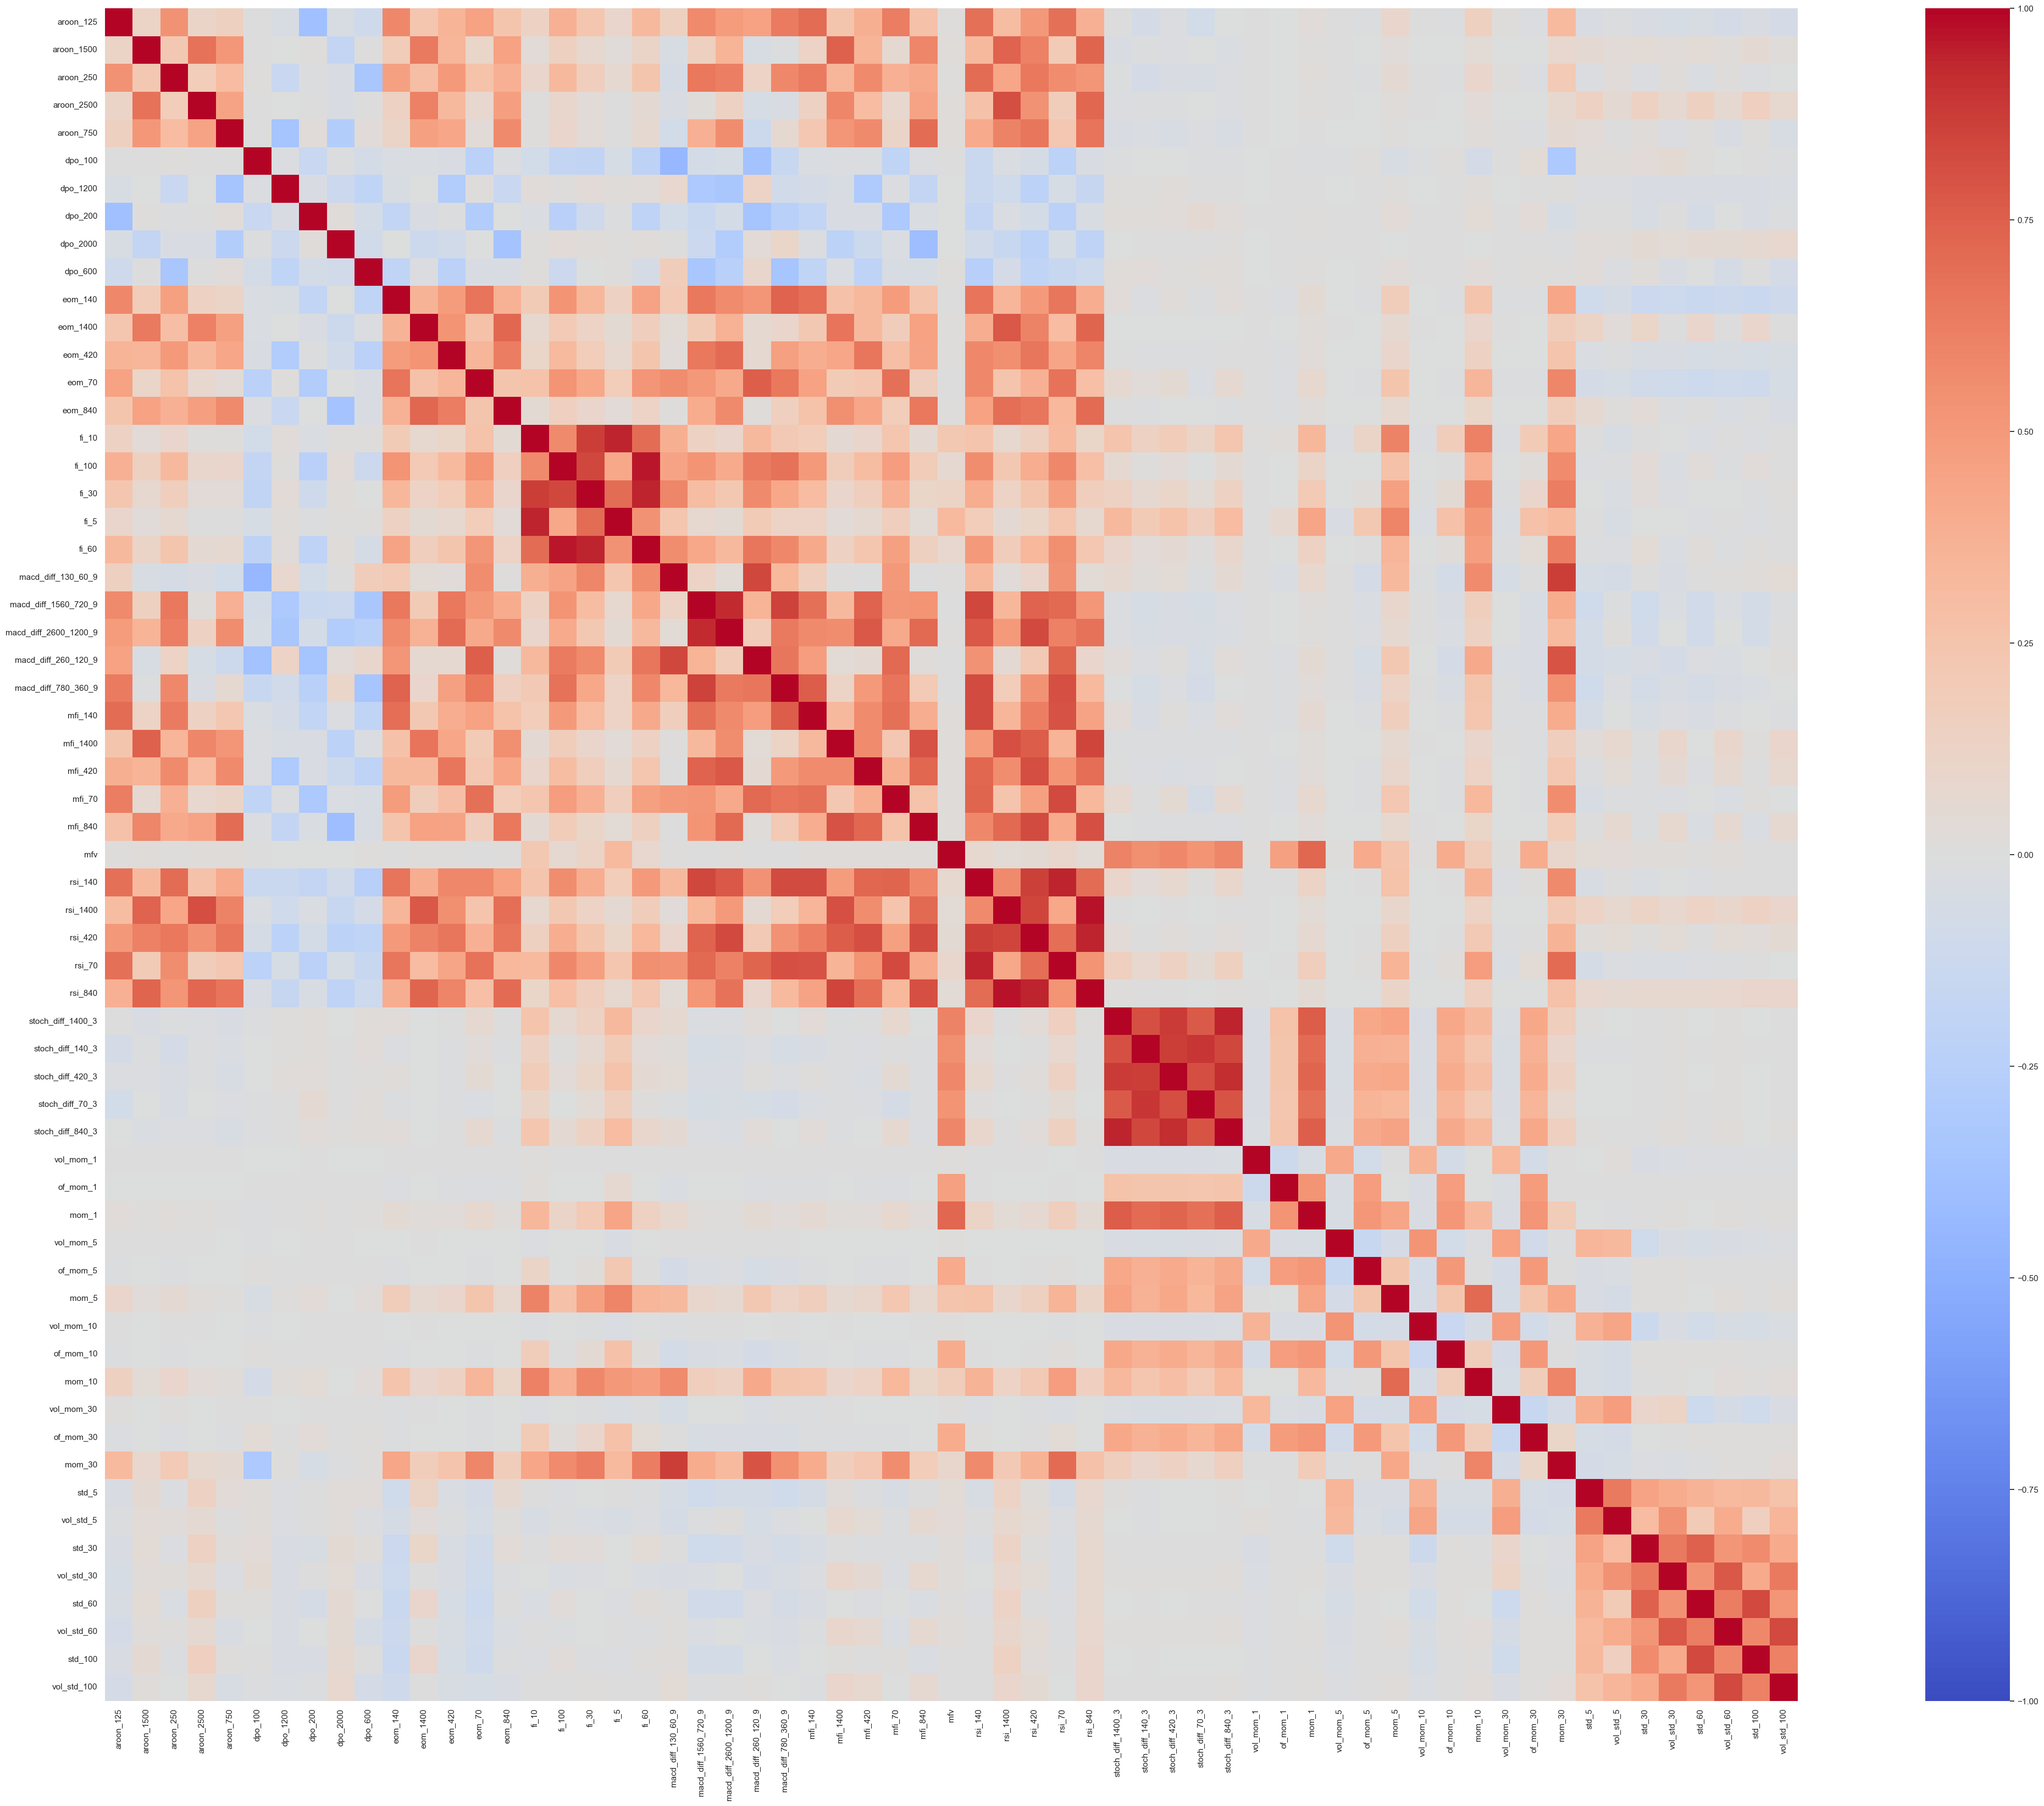

In [40]:
plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [41]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list


array([['aroon_2500', 'rsi_1400'],
       ['eom_1400', 'rsi_1400'],
       ['eom_70', 'macd_diff_260_120_9'],
       ['fi_10', 'fi_30'],
       ['fi_10', 'fi_5'],
       ['fi_100', 'fi_30'],
       ['fi_100', 'fi_60'],
       ['fi_30', 'fi_60'],
       ['macd_diff_130_60_9', 'macd_diff_260_120_9'],
       ['macd_diff_130_60_9', 'mom_30'],
       ['macd_diff_1560_720_9', 'macd_diff_2600_1200_9'],
       ['macd_diff_1560_720_9', 'macd_diff_780_360_9'],
       ['macd_diff_1560_720_9', 'rsi_140'],
       ['macd_diff_2600_1200_9', 'mfi_420'],
       ['macd_diff_2600_1200_9', 'rsi_140'],
       ['macd_diff_2600_1200_9', 'rsi_420'],
       ['macd_diff_260_120_9', 'mom_30'],
       ['macd_diff_780_360_9', 'mfi_140'],
       ['macd_diff_780_360_9', 'rsi_140'],
       ['macd_diff_780_360_9', 'rsi_70'],
       ['mfi_140', 'rsi_140'],
       ['mfi_140', 'rsi_70'],
       ['mfi_1400', 'mfi_840'],
       ['mfi_1400', 'rsi_1400'],
       ['mfi_1400', 'rsi_420'],
       ['mfi_1400', 'rsi_840'],
      

In [42]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['fi_30', 'fi_5', 'fi_60', 'macd_diff_2600_1200_9',
       'macd_diff_260_120_9', 'macd_diff_780_360_9', 'mfi_140', 'mfi_420',
       'mfi_840', 'mom_30', 'rsi_140', 'rsi_1400', 'rsi_420', 'rsi_70',
       'rsi_840', 'std_60', 'stoch_diff_1400_3', 'stoch_diff_140_3',
       'stoch_diff_420_3', 'stoch_diff_70_3', 'stoch_diff_840_3',
       'vol_std_60'], dtype='<U21')

In [43]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

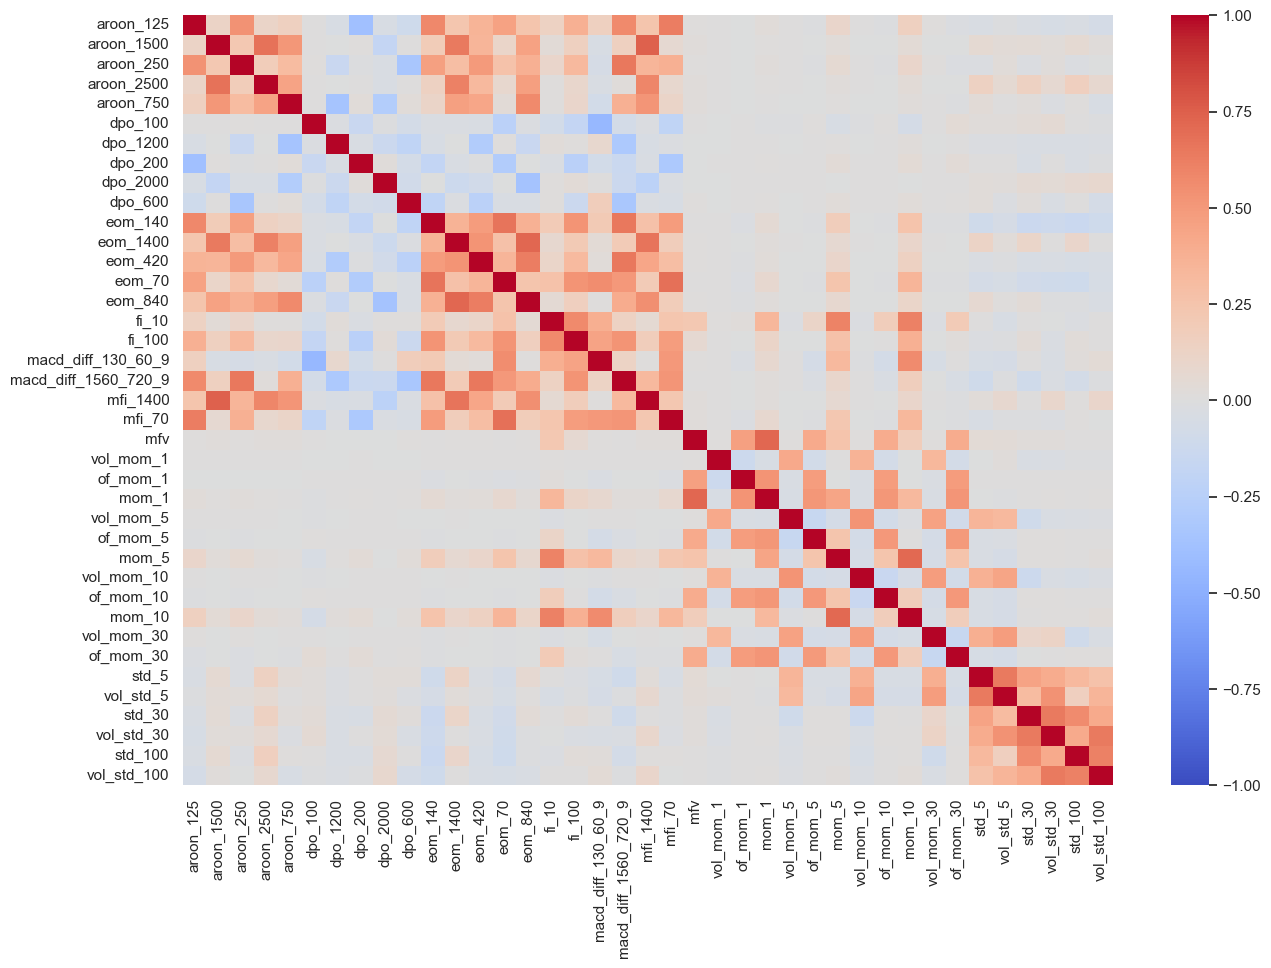

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

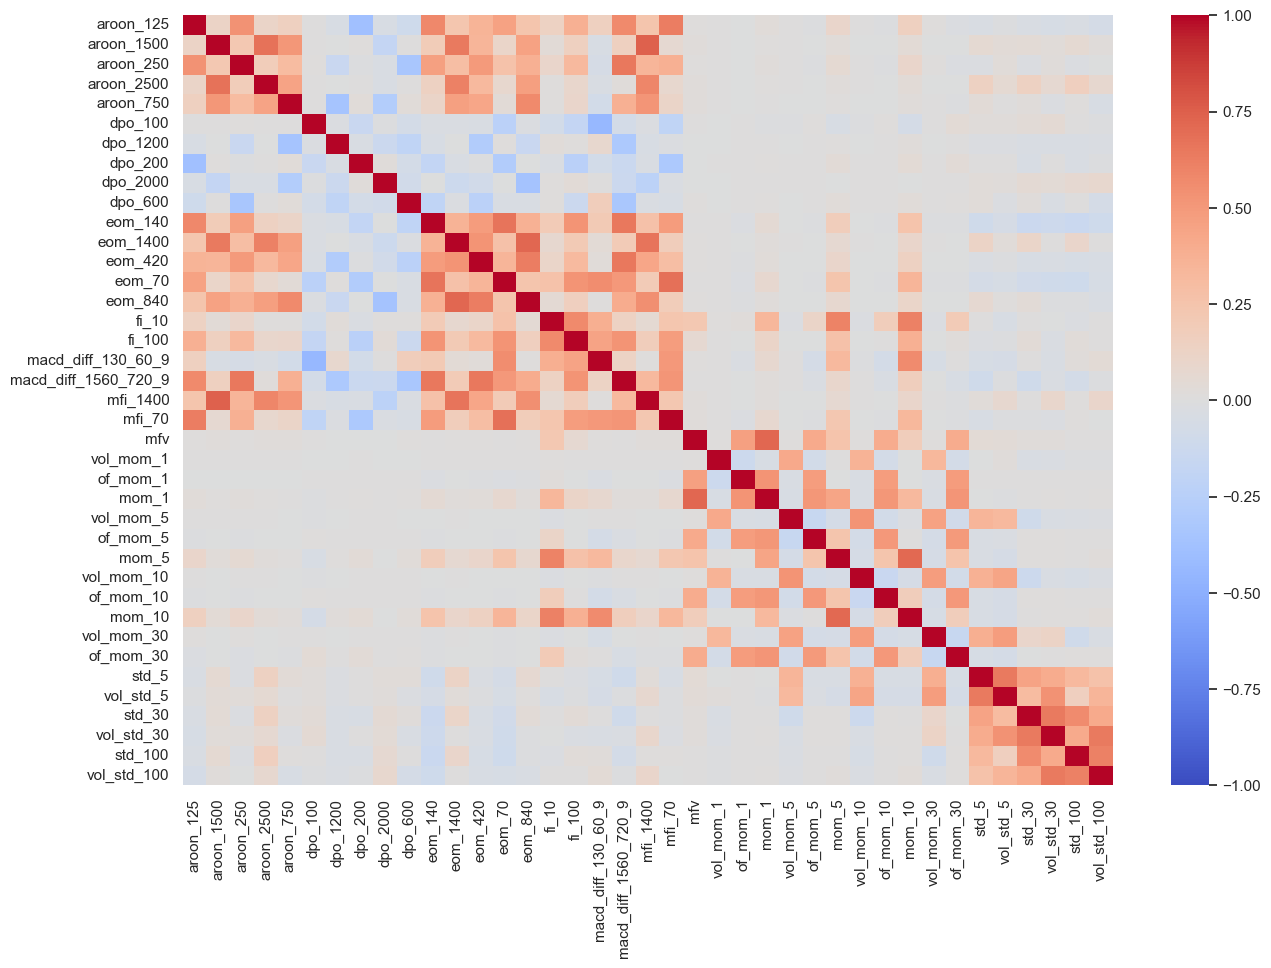

In [45]:
corr2 = mkt1.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [46]:
raw_X = mkt1.shift(1).copy()

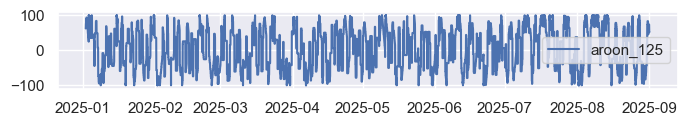

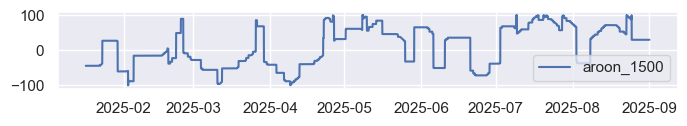

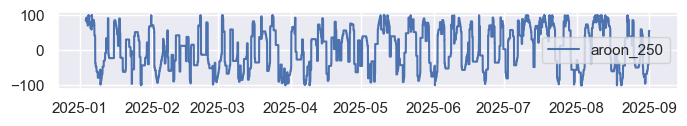

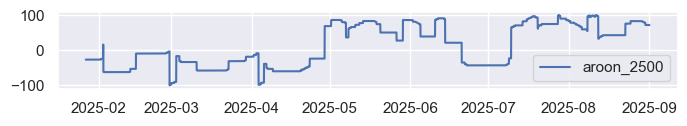

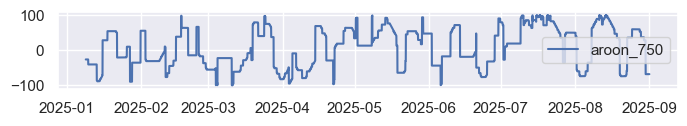

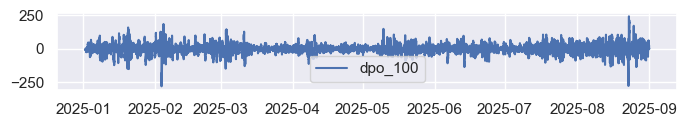

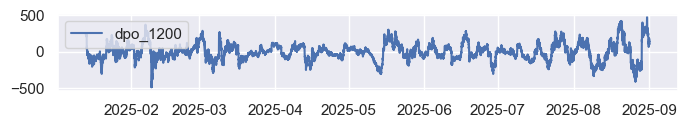

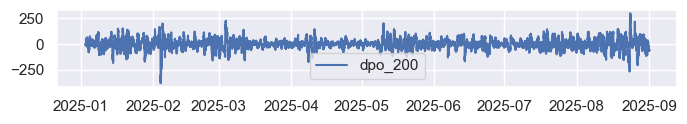

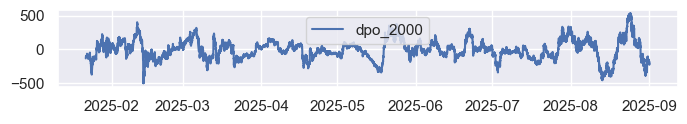

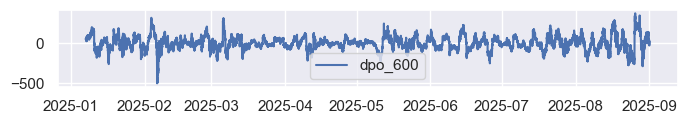

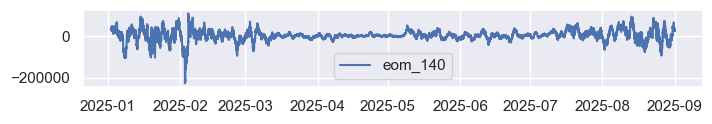

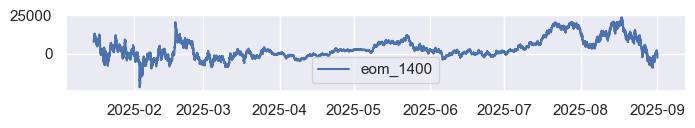

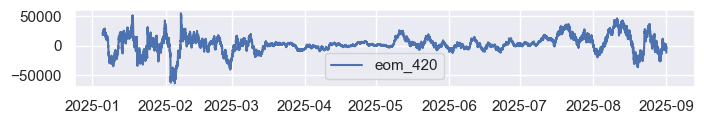

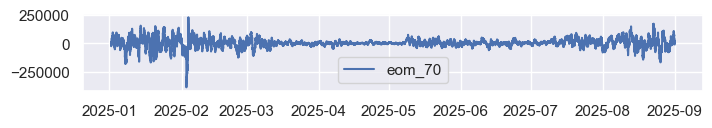

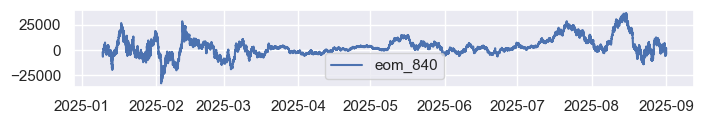

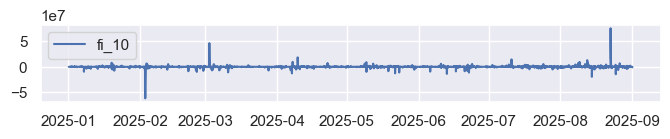

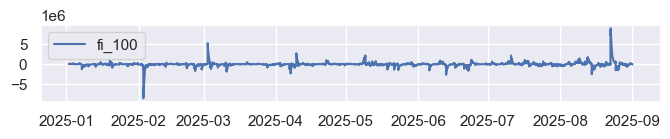

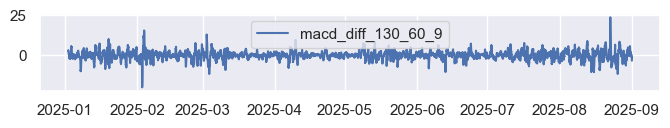

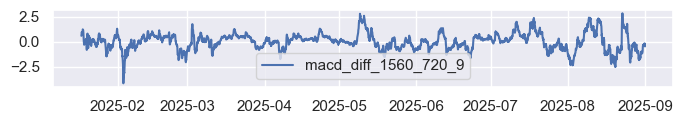

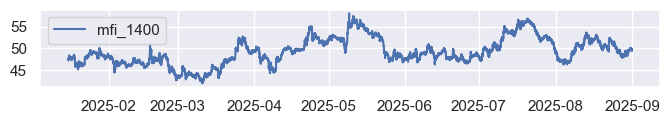

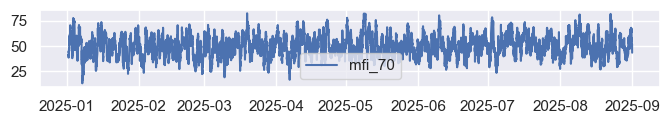

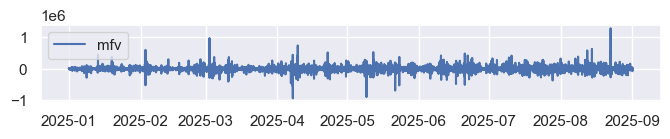

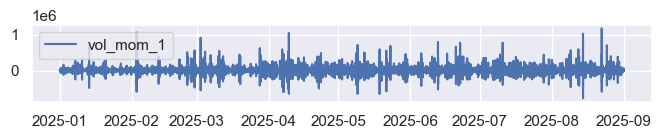

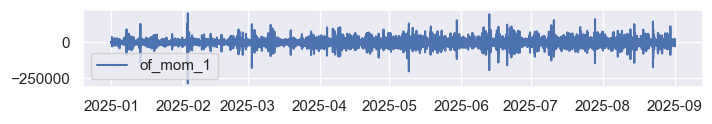

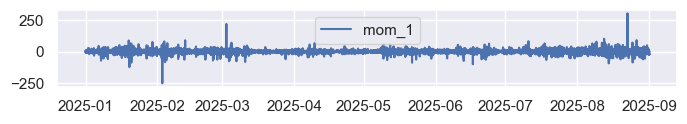

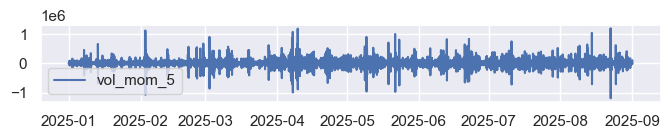

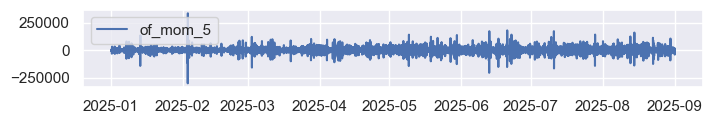

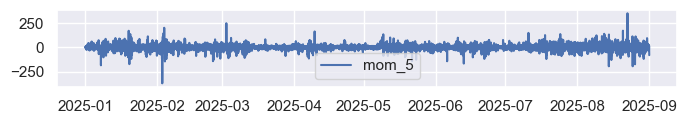

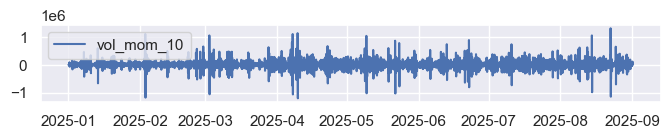

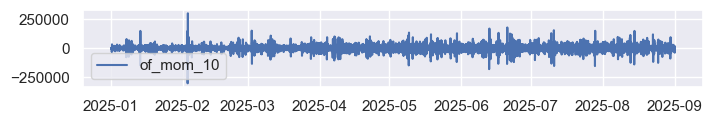

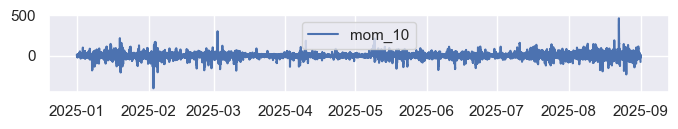

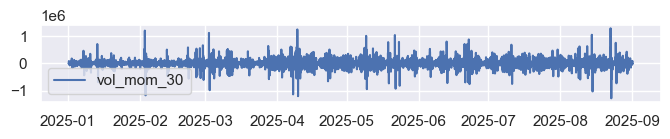

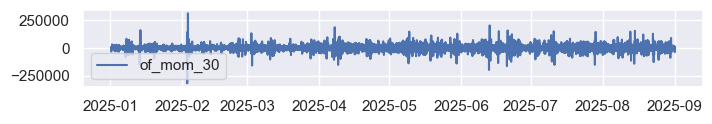

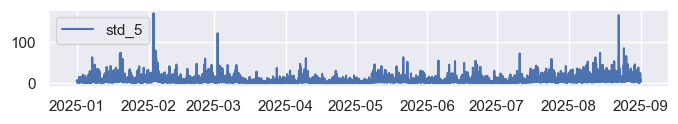

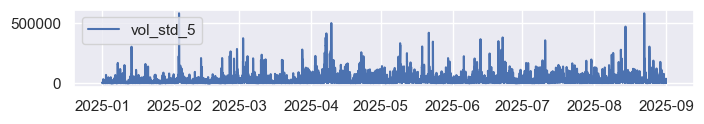

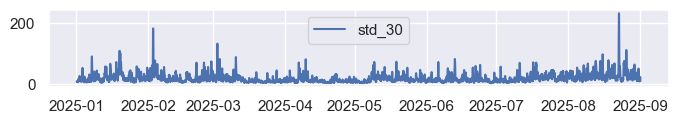

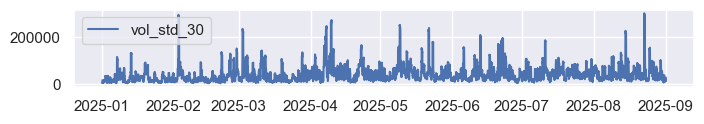

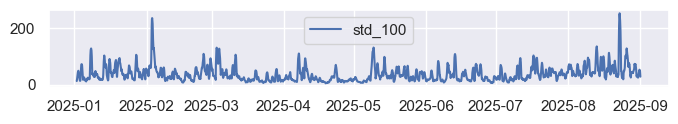

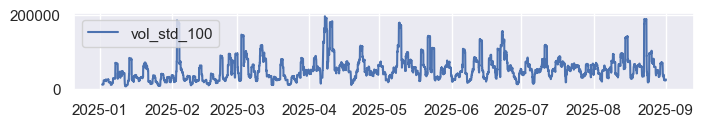

In [47]:
for i in raw_X.columns:
    plt.figure(figsize=(8,1))
    plt.plot(raw_X[i])
    plt.legend([i])

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [48]:
train_index = y.loc[:end_date_train]
test_index = y.loc[start_date_test:]

In [49]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [50]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [51]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [52]:
components_ = pca.components_

In [53]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt1.columns).T

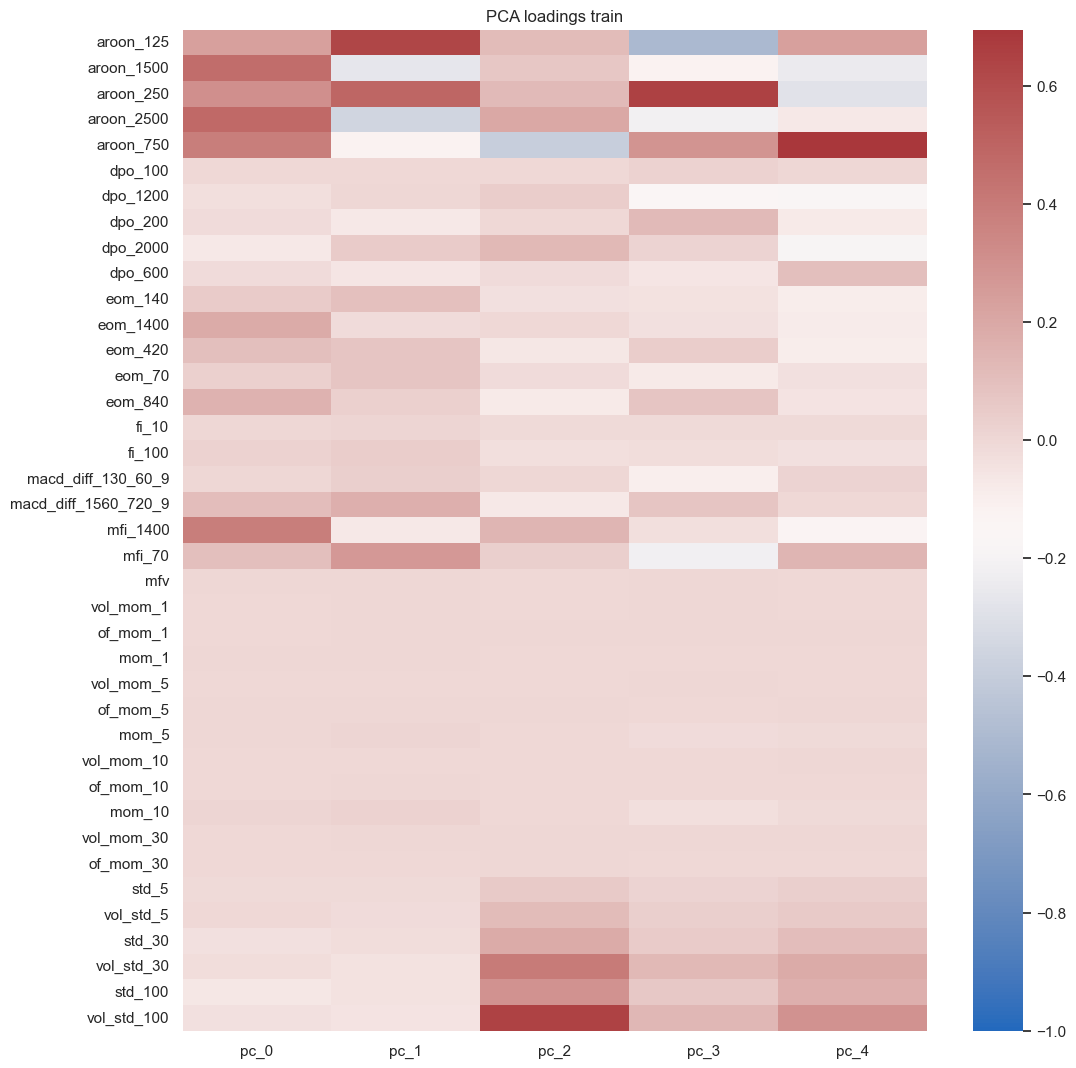

In [54]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

**Deep Autoencoders**

Non-Linear stacked autoencoders

https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

In [55]:
x = scaled_X_train.copy()

epochs=100
dimension=5

In [56]:
keras.backend.clear_session()

In [57]:
nl_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[x.shape[1]], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(dimension, activation='selu'),
])

nl_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[dimension], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(x.shape[1], activation='relu'),
])

nl_autoencoder = keras.models.Sequential([nl_encoder, nl_decoder])
nl_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))
nl_autoencoder.summary()


history = nl_autoencoder.fit(x,x, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=10)],
                             verbose=1)

2025-12-22 23:01:49.524936: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-22 23:01:49.524957: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-22 23:01:49.524963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-22 23:01:49.524980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-22 23:01:49.524992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 5)              │         1,195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 39)             │         1,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424 (9.47 KB)

 Trainable params: 2,424 (9.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
  1/191 ━━━━━━━━━━━━━━━━━━━━ 45s 240ms/step - loss: 0.6243

2025-12-22 23:01:49.776892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6803
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7071
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7098
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7075
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7027
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6974
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6928
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6892
Epoch 9/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6845
Epoch 10/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6812
Epoch 11/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6815


In [58]:
encoded_X_train = nl_encoder.predict(scaled_X_train)
encoded_X_train = pd.DataFrame(encoded_X_train, index=scaled_X_train.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

encoded_X_test = nl_encoder.predict(scaled_X_test)
encoded_X_test = pd.DataFrame(encoded_X_test, index=scaled_X_test.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [59]:
encoded_X_train

encoded_0  encoded_1  encoded_2  encoded_3  encoded_4
open_time                                                                 
2025-01-27 01:15:00   0.534325   0.749184   1.527626  -0.682472  -1.597705
2025-01-27 01:30:00   0.556968   0.758395   1.536933  -0.684996  -1.596715
2025-01-27 02:30:00   0.550058   0.736385   1.603178  -0.681218  -1.603165
2025-01-27 03:00:00   0.576751   0.737378   1.584258  -0.664435  -1.602712
2025-01-27 03:15:00   0.609965   0.760157   1.607916  -0.634417  -1.606898
...                        ...        ...        ...        ...        ...
2025-06-01 21:45:00   0.813248   0.981153   1.756406  -0.351946  -1.608338
2025-06-01 22:00:00   0.822705   0.981856   1.770654  -0.350655  -1.607893
2025-06-01 22:30:00   0.813565   0.970685   1.767400  -0.343554  -1.606283
2025-06-01 23:00:00   0.838364   0.981495   1.777460  -0.354688  -1.606239
2025-06-01 23:45:00   0.844475   0.975813   1.788394  -0.353939  -1.605745

[6090 rows x 5 columns]

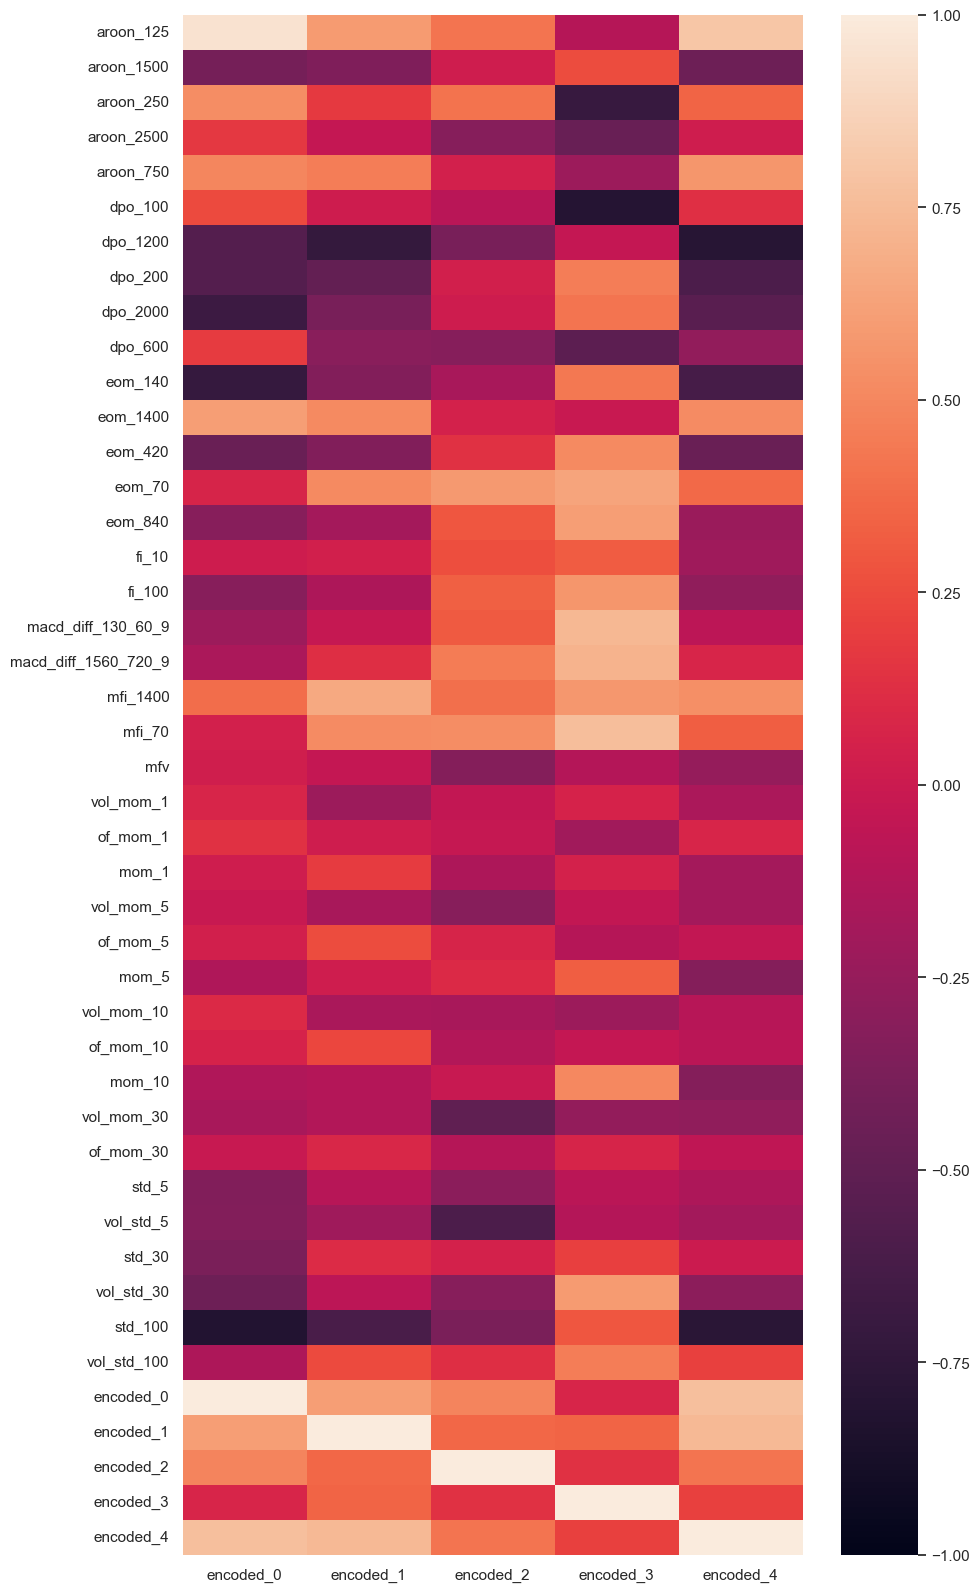

In [60]:
corr_encoded = scaled_X_test.join(encoded_X_train).corr().iloc[-5:].T

plt.figure(figsize=(10,20))
sns.heatmap(corr_encoded,vmin=-1,vmax=1)
plt.show()

COMPARE PCA and Non-linear autoencoder

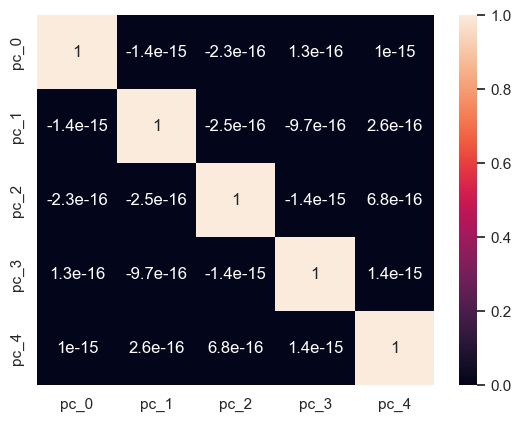

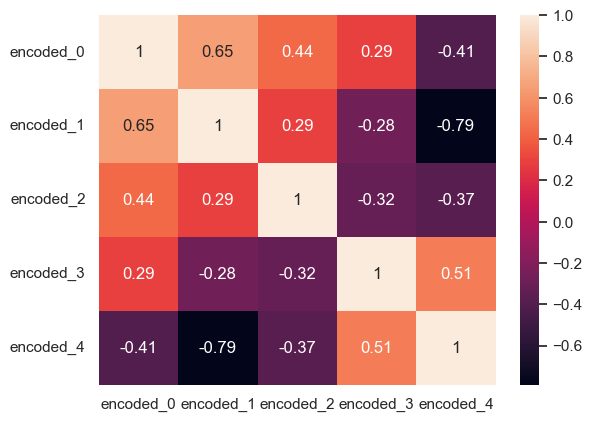

In [61]:
# correlation (linearly)
sns.heatmap(pca_X_train.corr(),annot=True)
plt.show()

sns.heatmap(encoded_X_train.corr(),annot=True)
plt.show()

# Machine Learning Model

## Hyper parameter tuning

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, it helps.

or F1 socre in general(*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. 
- Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [62]:
train_X = pca_X_train.copy() 
# or
#train_X= encoded_X_train.copy()

test_X = pca_X_test.copy()
# or
#test_X= encoded_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [63]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [64]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [65]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20251222_150210"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
Memory Avail:       5.34 GB / 16.00 GB (33.4%)
Disk Space Avail:   162.48 GB / 460.43 GB (35.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for tabular data. Massively better than 'best' on datasets <100000 samples by using new Tabula

[1000]	valid_set's binary_logloss: 0.147615	valid_set's precision: 0.959016


	0.9643	 = Validation score   (precision)
	5.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=8, gpus=0, mem=0.0/5.5 GB
	0.9643	 = Validation score   (precision)
	3.37s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	Fitting with cpus=8, gpus=0, mem=0.0/5.5 GB
	0.9668	 = Validation score   (precision)
	0.61s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestEntr ...
	Fitting with cpus=8, gpus=0, mem=0.0/5.4 GB
	0.9695	 = Validation score   (precision)
	0.58s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=8, gpus=0
	0.9721	 = Validation score   (precision)
	2.5s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	Fitting with cpus=8, gpus=0, mem=0.0/5.4 GB
	0.9563	 = Validation score   (precision)
	0.36s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesEntr .

limitation
- shuffle 
- not good cv for finance data

In [66]:
result = predictor.leaderboard(test_data, silent=True)
result

model  score_test  score_val eval_metric  pred_time_test  \
0              LightGBM    0.644611   0.964286   precision        0.026526   
1      RandomForestGini    0.614517   0.966759   precision        0.037668   
2         LightGBMLarge    0.611212   0.974930   precision        0.011344   
3   WeightedEnsemble_L2    0.610830   0.975000   precision        0.056587   
4      RandomForestEntr    0.609921   0.969529   precision        0.035432   
5        ExtraTreesGini    0.604457   0.956284   precision        0.056598   
6              CatBoost    0.602525   0.972145   precision        0.005429   
7        ExtraTreesEntr    0.602487   0.964187   precision        0.044375   
8            LightGBMXT    0.602372   0.964286   precision        0.064917   
9               XGBoost    0.595645   0.966851   precision        0.013139   
10       NeuralNetTorch    0.580673   0.969014   precision        0.009636   
11      NeuralNetFastAI    0.579886   0.919890   precision        0.026510   

    pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0        0.005886   3.370542                 0.026526                0.005886   
1        0.026862   0.605841                 0.037668                0.026862   
2        0.002153   5.595995                 0.011344                0.002153   
3        0.029265   6.004390                 0.000868                0.002459   
4        0.026095   0.576841                 0.035432                0.026095   
5        0.027279   0.364514                 0.056598                0.027279   
6        0.001765   2.500267                 0.005429                0.001765   
7        0.024653   0.291664                 0.044375                0.024653   
8        0.011738   5.727178                 0.064917                0.011738   
9        0.001892   1.356246                 0.013139                0.001892   
10       0.002896  20.173870                 0.009636                0.002896   
11       0.007505   2.586062                 0.026510                0.007505   

    fit_time_marginal  stack_level  can_infer  fit_order  
0            3.370542            1       True          2  
1            0.605841            1       True          3  
2            5.595995            1       True         11  
3            0.116731            2       True         12  
4            0.576841            1       True          4  
5            0.364514            1       True          6  
6            2.500267            1       True          5  
7            0.291664            1       True          7  
8            5.727178            1       True          1  
9            1.356246            1       True          9  
10          20.173870            1       True         10  
11           2.586062            1       True          8

In [67]:
best_model = result.model[0]

In [68]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

LightGBM 's predictions:  
 open_time
2025-06-01 00:30:00    1.0
2025-06-01 00:45:00    1.0
2025-06-01 01:00:00    1.0
2025-06-01 02:15:00    1.0
2025-06-01 02:30:00    1.0
                      ... 
2025-08-28 23:30:00    1.0
2025-08-28 23:45:00    1.0
2025-08-29 00:15:00    1.0
2025-08-29 03:30:00   -1.0
2025-08-29 04:15:00   -1.0
Name: y, Length: 4398, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [69]:
for i in result.model:
    print(i, "'s Feature Importance")
    fi = predictor.feature_importance(test_data, model=i, silent=True)
    print(fi)
    print('\n')

LightGBM 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_1    0.036217  0.005704  0.000071  5  0.047961  0.024472
pc_4    0.032323  0.003802  0.000023  5  0.040153  0.024494
pc_3    0.026041  0.003343  0.000032  5  0.032924  0.019159
pc_0    0.018977  0.006549  0.001462  5  0.032462  0.005492
pc_2    0.010641  0.003614  0.001378  5  0.018082  0.003199


RandomForestGini 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_4    0.014260  0.004272  0.000861  5  0.023055  0.005465
pc_2    0.012596  0.002460  0.000166  5  0.017661  0.007530
pc_1    0.010709  0.005623  0.006536  5  0.022288 -0.000870
pc_3    0.004759  0.001759  0.001883  5  0.008381  0.001137
pc_0   -0.015070  0.005461  0.998249  5 -0.003826 -0.026313


LightGBMLarge 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_4    0.010475  0.006990  0.014271  5  0.024867 -0.003917
pc_1    0.007733  0.004725  0.010794  5  0.017462 

## Results with PnL

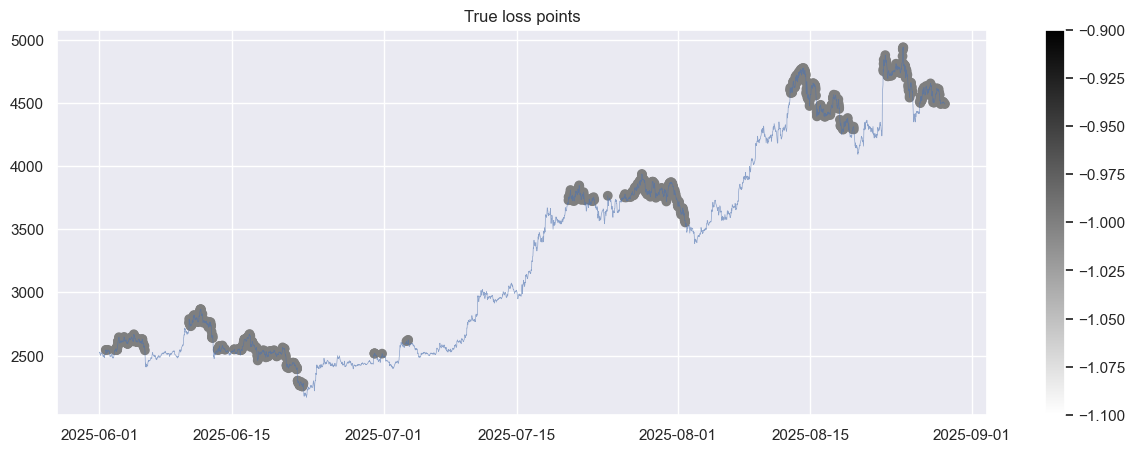

In [70]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

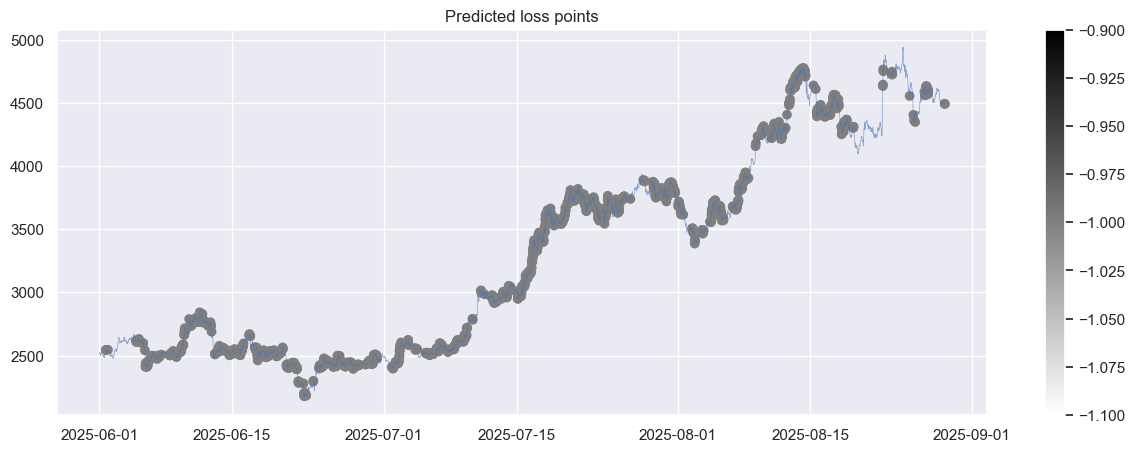

In [71]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [72]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

y
 1.0    1549
-1.0     854
Name: count, dtype: int64

In [73]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())

이익확률 pi:  0.6446109030378693


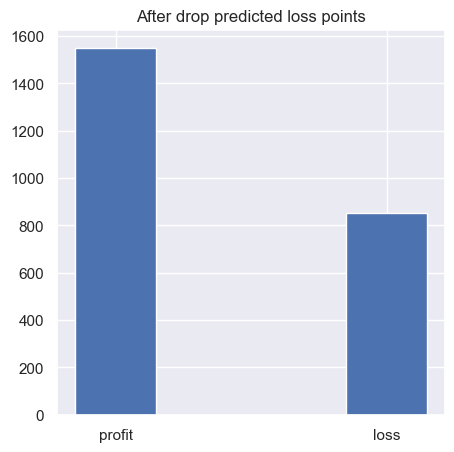

In [74]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.8

In [75]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

-1.0       1.0
open_time                              
2025-06-01 00:30:00  0.025244  0.974756
2025-06-01 00:45:00  0.024133  0.975867
2025-06-01 01:00:00  0.024133  0.975867
2025-06-01 02:15:00  0.036015  0.963985
2025-06-01 02:30:00  0.048915  0.951085
...                       ...       ...
2025-08-28 23:30:00  0.266372  0.733628
2025-08-28 23:45:00  0.270816  0.729184
2025-08-29 00:15:00  0.275260  0.724740
2025-08-29 03:30:00  0.234225  0.765775
2025-08-29 04:15:00  0.249852  0.750148

[4398 rows x 2 columns]

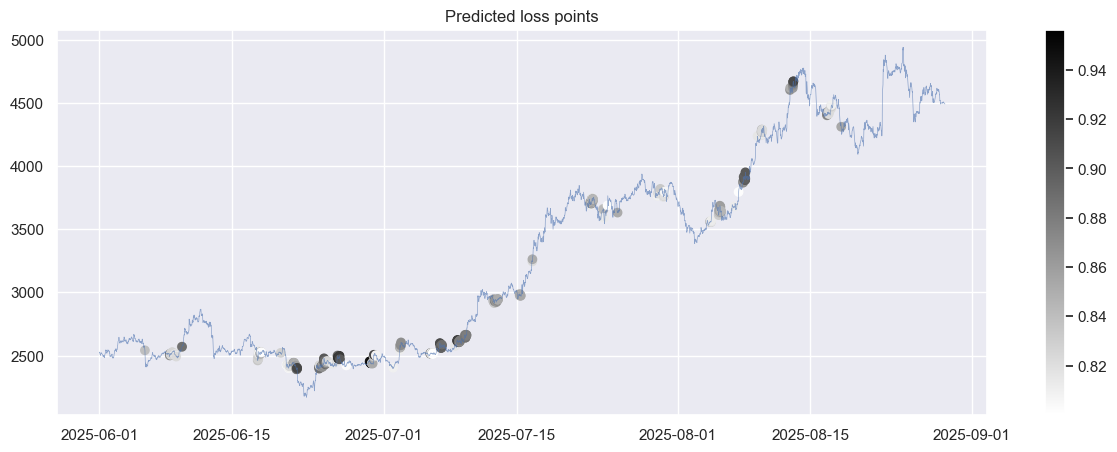

In [76]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.8]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [77]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.8].index)
predlabel2.value_counts()

y
 1.0    2539
-1.0    1489
Name: count, dtype: int64

In [78]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())

이익확률 pi:  0.6303376365441906


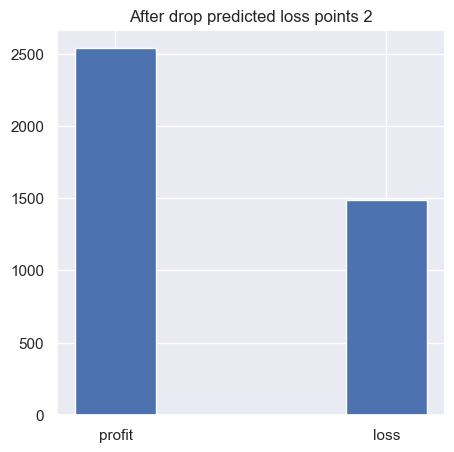

In [79]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [80]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>0.5].index)
finret

open_time
2025-06-01 00:30:00    0.048804
2025-06-01 00:45:00    0.055221
2025-06-01 01:00:00    0.054374
2025-06-01 02:15:00    0.050746
2025-06-01 02:30:00    0.049653
                         ...   
2025-08-28 23:30:00   -0.054170
2025-08-28 23:45:00   -0.052021
2025-08-29 00:15:00   -0.051715
2025-08-29 03:30:00   -0.052862
2025-08-29 04:15:00   -0.052366
Name: ret, Length: 2770, dtype: float64

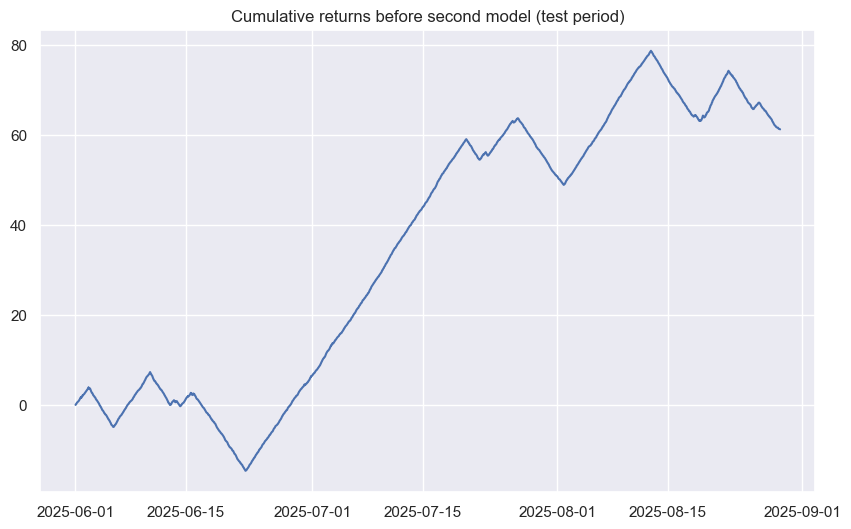

In [81]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

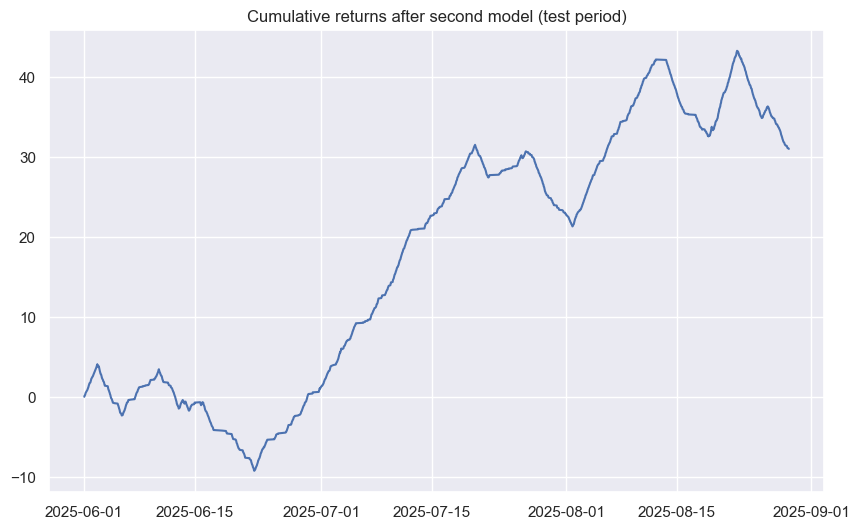

In [82]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### Trading

#### bet sizing

- Kelly rules (when betting data is normally dist.)
- Use predicted probabilities as bet confidence (suggested by DePrado)

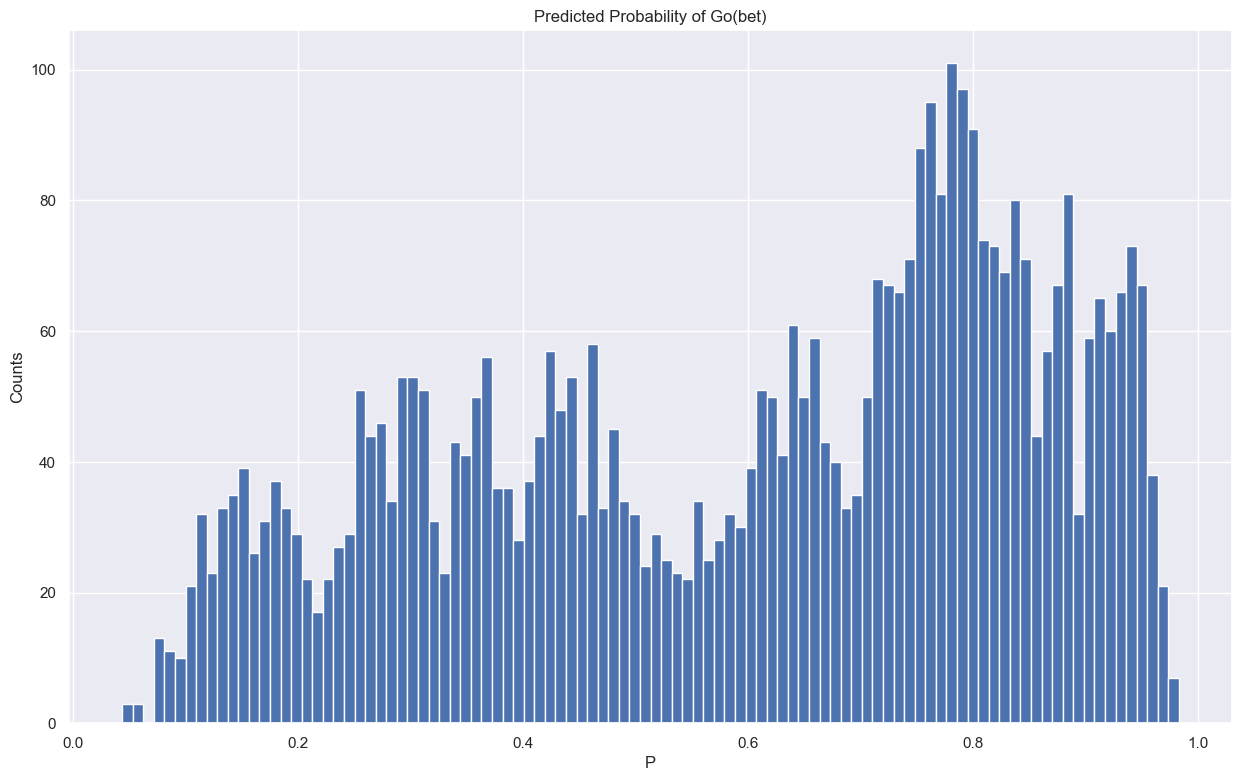

In [83]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

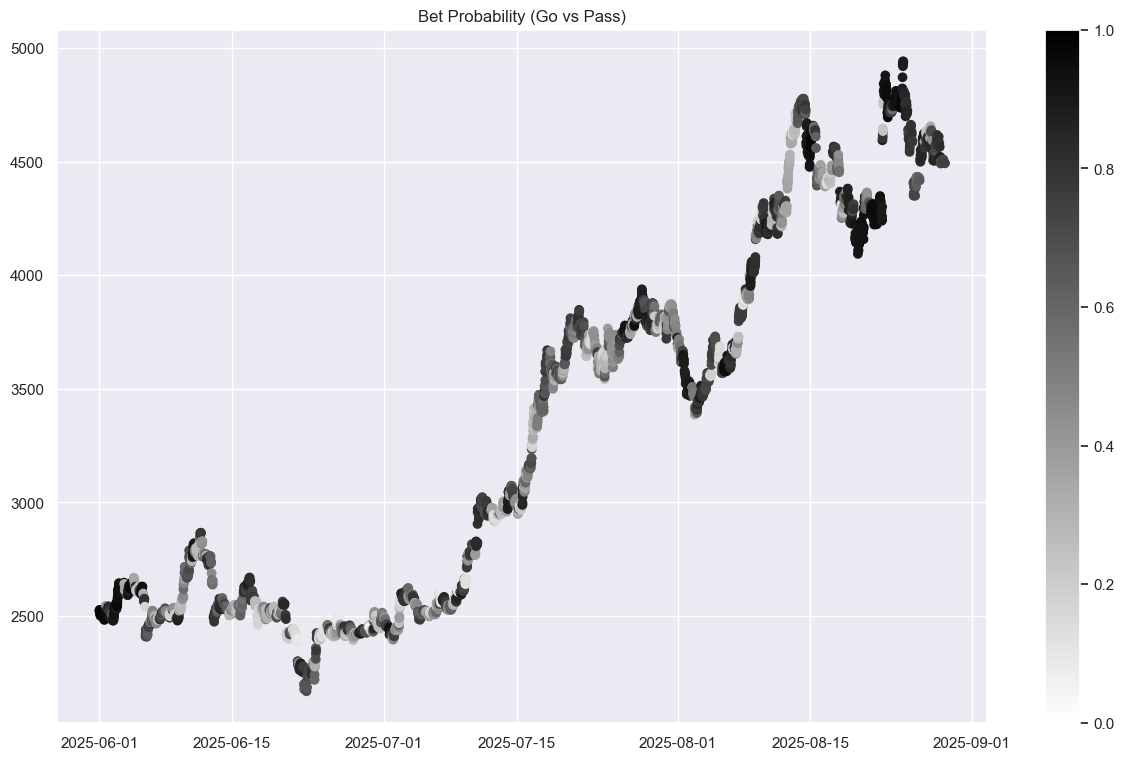

In [84]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

- not perfect yet

In [85]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [86]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [87]:
prob = p.copy()

m = get_signal(prob, 2)
m = discretize(m, 0.25)

In [88]:
m

open_time
2025-06-01 00:30:00    1.0
2025-06-01 00:45:00    1.0
2025-06-01 01:00:00    1.0
2025-06-01 02:15:00    1.0
2025-06-01 02:30:00    1.0
                      ... 
2025-08-28 23:30:00    0.5
2025-08-28 23:45:00    0.5
2025-08-29 00:15:00    0.5
2025-08-29 03:30:00    0.5
2025-08-29 04:15:00    0.5
Name: 1.0, Length: 4398, dtype: float64

In [89]:
# we only do long position betting

m.loc[m[m<0].index] = 0
m

open_time
2025-06-01 00:30:00    1.0
2025-06-01 00:45:00    1.0
2025-06-01 01:00:00    1.0
2025-06-01 02:15:00    1.0
2025-06-01 02:30:00    1.0
                      ... 
2025-08-28 23:30:00    0.5
2025-08-28 23:45:00    0.5
2025-08-29 00:15:00    0.5
2025-08-29 03:30:00    0.5
2025-08-29 04:15:00    0.5
Name: 1.0, Length: 4398, dtype: float64

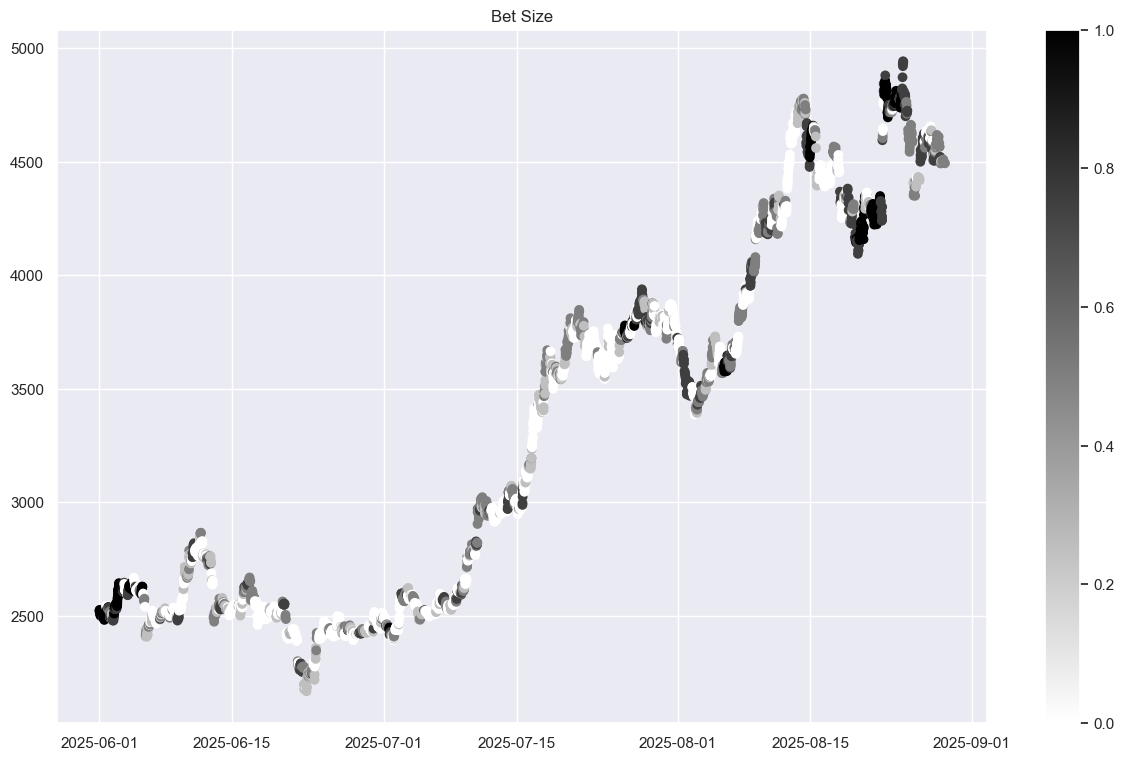

In [90]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [91]:
barrier_t = barrier.loc[y_true2.index]

In [92]:
initial_money=1
bet_size = m*initial_money

In [93]:
wallet = tb.get_wallet_v2(close,barrier_t,initial_money, bet_size, fee_rate=0.0005, slippage=0.0001)
wallet

money_spent  money_receive  buy_amount  sell_amount  \
open_time                                                                  
2025-01-01 00:00:00          0.0            0.0         0.0          0.0   
2025-01-01 00:15:00          0.0            0.0         0.0          0.0   
2025-01-01 00:30:00          0.0            0.0         0.0          0.0   
2025-01-01 00:45:00          0.0            0.0         0.0          0.0   
2025-01-01 01:00:00          0.0            0.0         0.0          0.0   
...                          ...            ...         ...          ...   
2025-08-31 22:45:00          0.0            0.0         0.0          0.0   
2025-08-31 23:00:00          0.0            0.0         0.0          0.0   
2025-08-31 23:15:00          0.0            0.0         0.0          0.0   
2025-08-31 23:30:00          0.0            0.0         0.0          0.0   
2025-08-31 23:45:00          0.0            0.0         0.0          0.0   

                     n_stock  cash_inventory    price  
open_time                                              
2025-01-01 00:00:00      0.0        1.000000  3347.40  
2025-01-01 00:15:00      0.0        1.000000  3348.62  
2025-01-01 00:30:00      0.0        1.000000  3355.36  
2025-01-01 00:45:00      0.0        1.000000  3362.90  
2025-01-01 01:00:00      0.0        1.000000  3359.62  
...                      ...             ...      ...  
2025-08-31 22:45:00      0.0    31822.893123  4442.72  
2025-08-31 23:00:00      0.0    31822.893123  4432.11  
2025-08-31 23:15:00      0.0    31822.893123  4405.76  
2025-08-31 23:30:00      0.0    31822.893123  4384.88  
2025-08-31 23:45:00      0.0    31822.893123  4389.58  

[23328 rows x 7 columns]

- I made this function for only stocks. For cryptocurrency your buy amount or sell amount can be float.
- There is still error in bet sizing. This function calculate buy amount as *bet_size* * *initial_cash*. It should be *bet_size* * *cash_inventory*.

In [94]:
eth_position = wallet.money_spent-wallet.money_receive
cash_position = wallet.cash_inventory.diff()

In [95]:
eth_position

open_time
2025-01-01 00:00:00    0.0
2025-01-01 00:15:00    0.0
2025-01-01 00:30:00    0.0
2025-01-01 00:45:00    0.0
2025-01-01 01:00:00    0.0
                      ... 
2025-08-31 22:45:00    0.0
2025-08-31 23:00:00    0.0
2025-08-31 23:15:00    0.0
2025-08-31 23:30:00    0.0
2025-08-31 23:45:00    0.0
Length: 23328, dtype: float64

In [96]:
positions = pd.DataFrame()
positions['ETH'] = eth_position
positions['cash'] = cash_position

In [97]:
positions

ETH  cash
open_time                     
2025-01-01 00:00:00  0.0   NaN
2025-01-01 00:15:00  0.0   0.0
2025-01-01 00:30:00  0.0   0.0
2025-01-01 00:45:00  0.0   0.0
2025-01-01 01:00:00  0.0   0.0
...                  ...   ...
2025-08-31 22:45:00  0.0   0.0
2025-08-31 23:00:00  0.0   0.0
2025-08-31 23:15:00  0.0   0.0
2025-08-31 23:30:00  0.0   0.0
2025-08-31 23:45:00  0.0   0.0

[23328 rows x 2 columns]

In [98]:
ret = barrier_t.ret
ret

open_time
2025-06-01 00:30:00    0.048804
2025-06-01 00:45:00    0.055221
2025-06-01 01:00:00    0.054374
2025-06-01 02:15:00    0.050746
2025-06-01 02:30:00    0.049653
                         ...   
2025-08-28 23:30:00   -0.054170
2025-08-28 23:45:00   -0.052021
2025-08-29 00:15:00   -0.051715
2025-08-29 03:30:00   -0.052862
2025-08-29 04:15:00   -0.052366
Name: ret, Length: 4398, dtype: float64

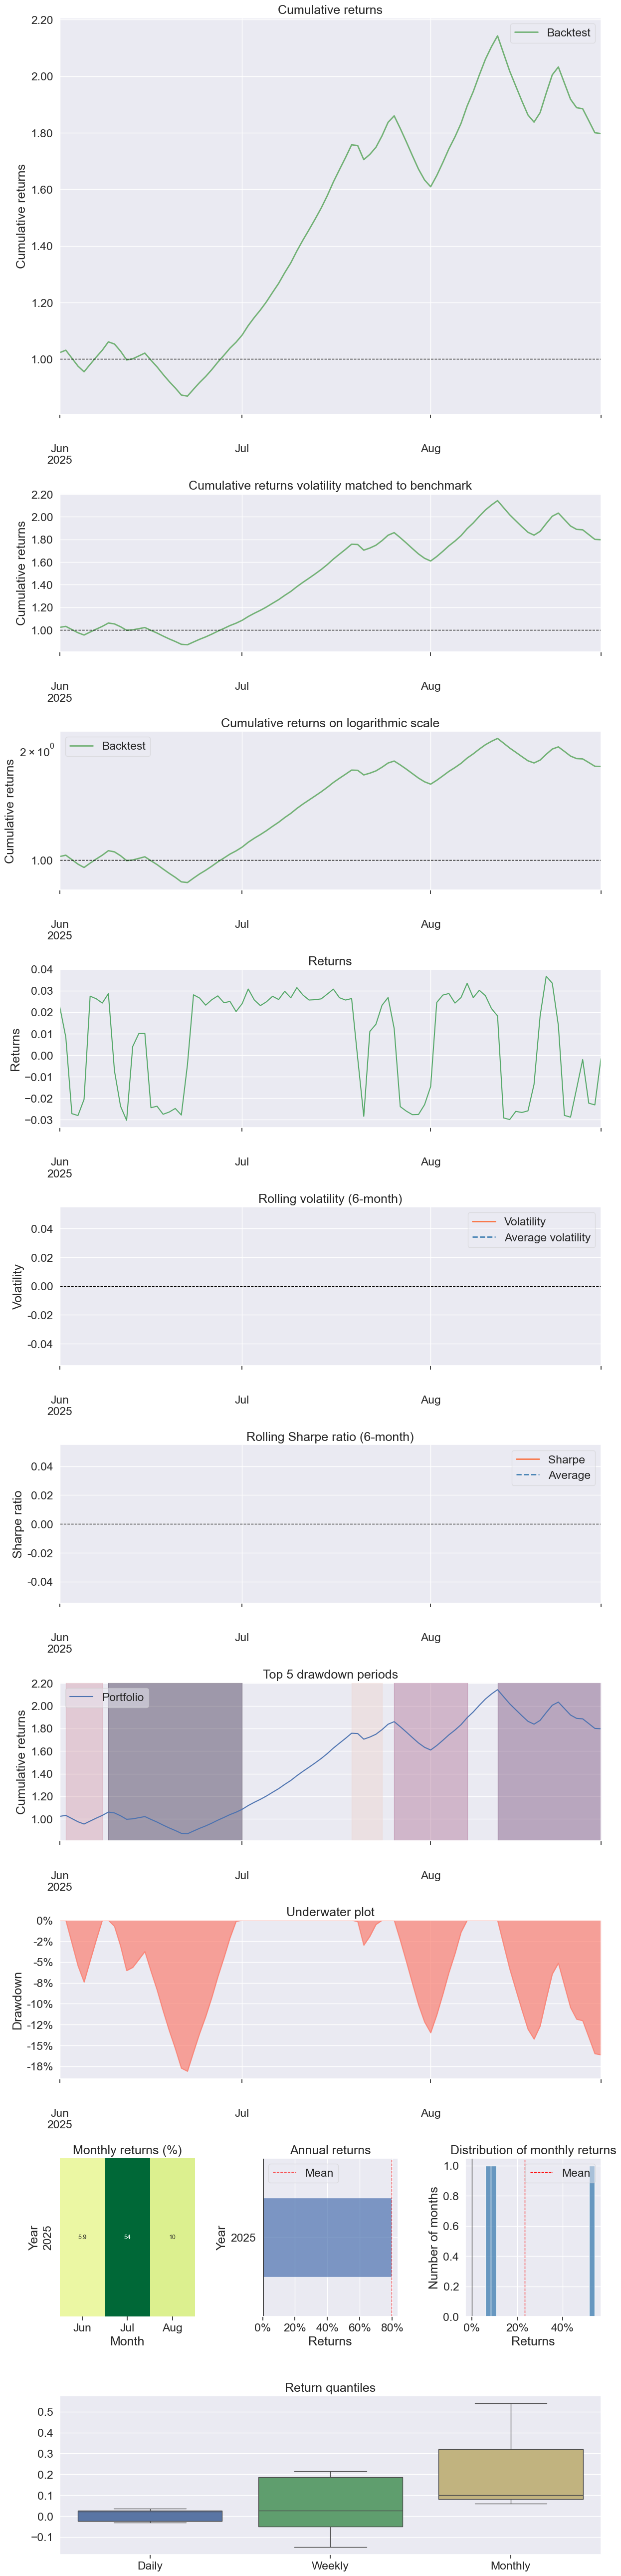

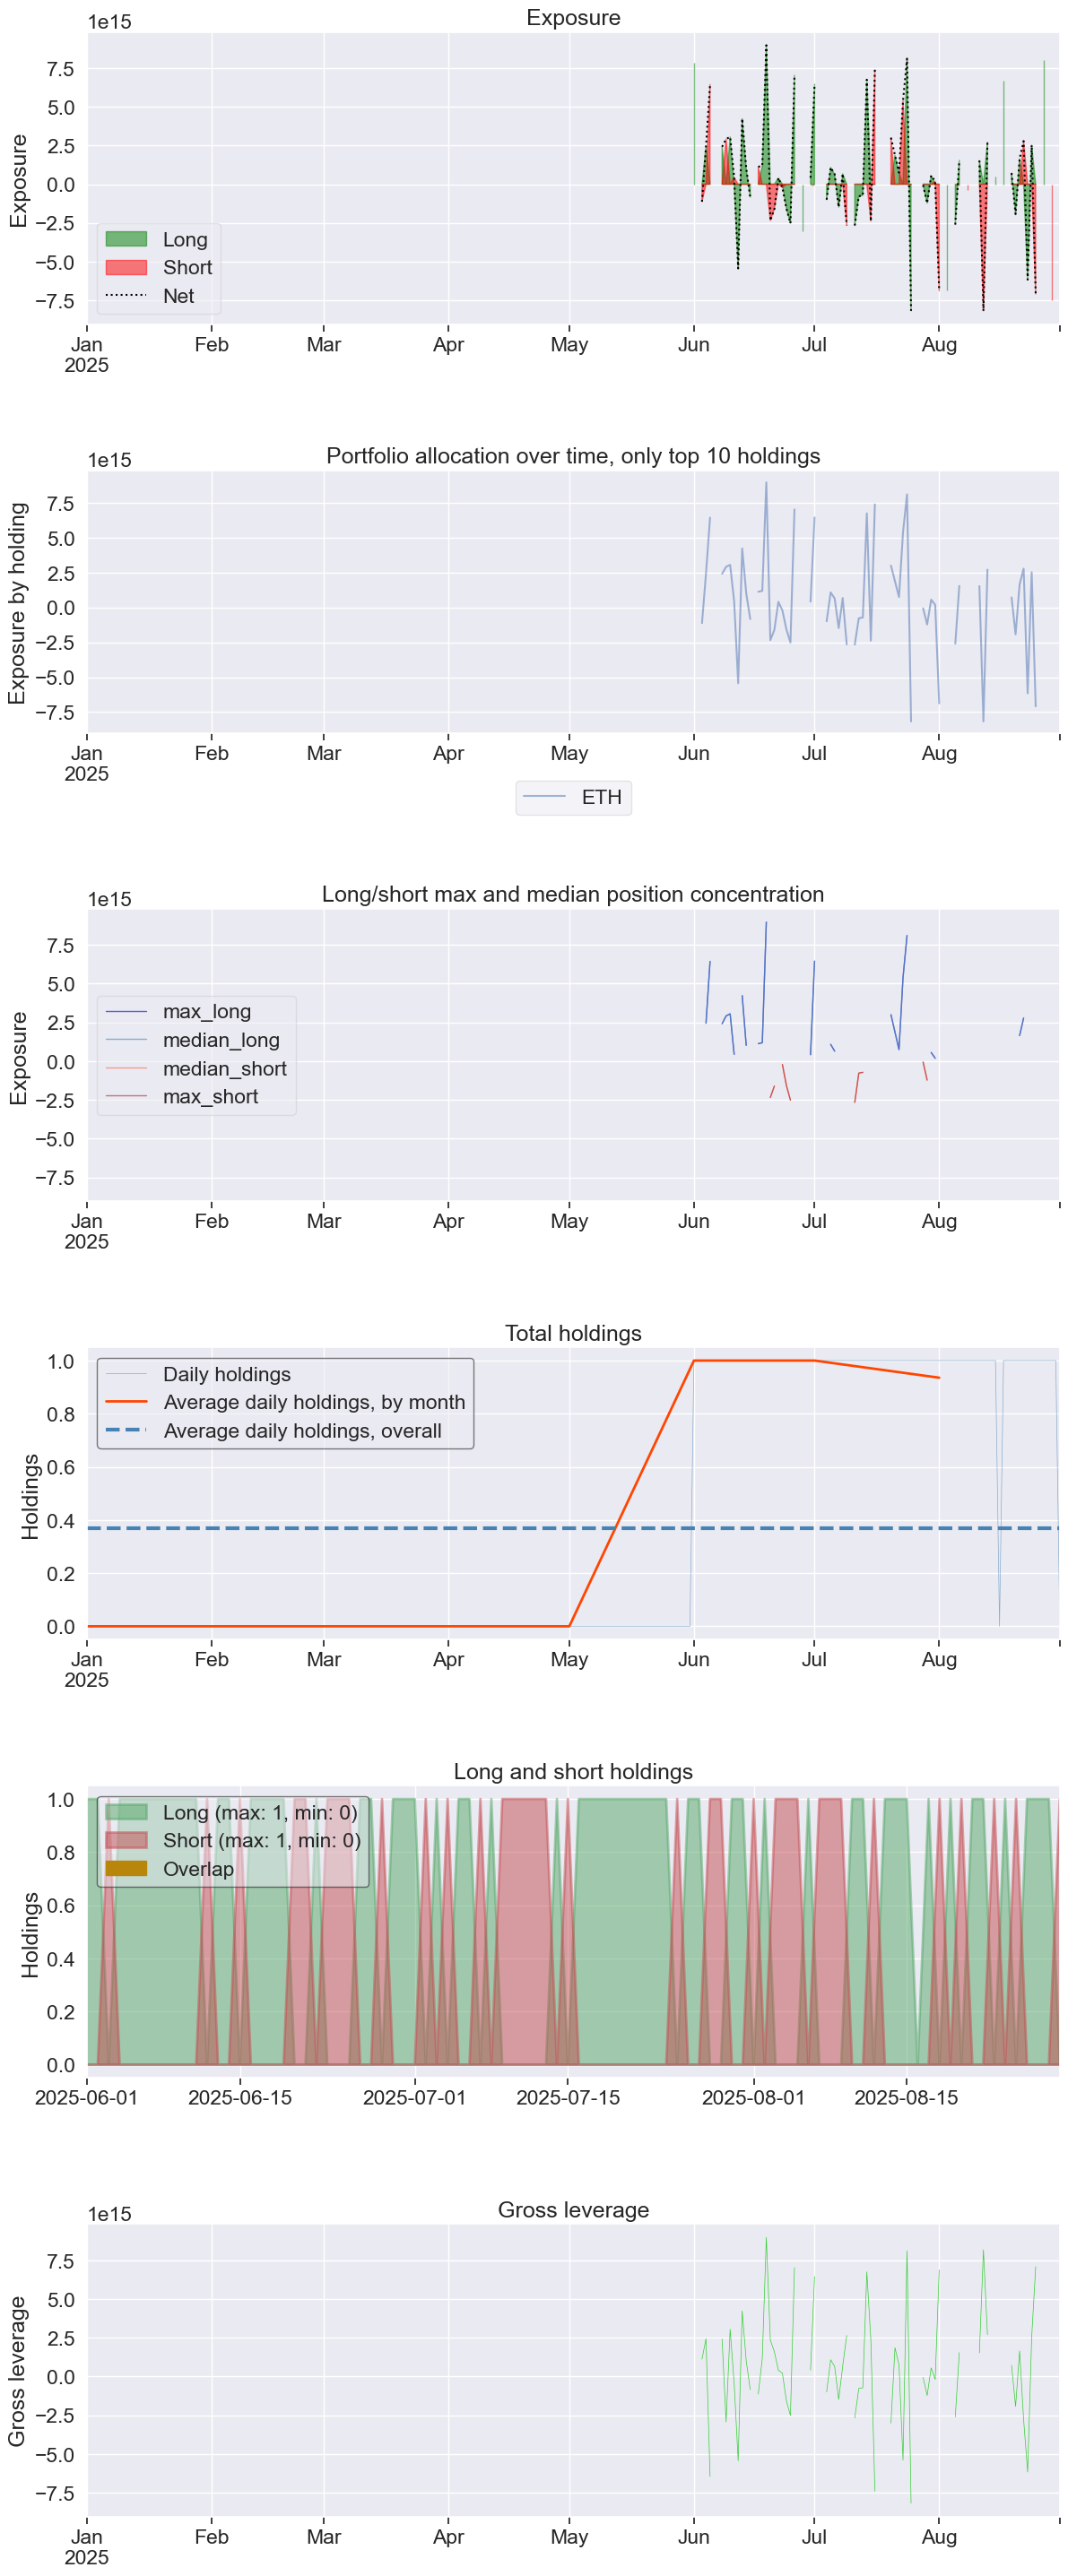

In [99]:
# 1. 将百分比收益率转换为小数
ret_daily = ret.resample('D').sum()
positions_daily = positions.resample('D').sum()

ret_pyfolio = ret_daily / 100.0

# 2. 规范化持仓数据 (可选，但建议检查)
# 确保 positions_daily 的最后一列是 'cash'，且总和代表了组合的总价值
# 如果您只想看收益率分析，可以暂时不传 positions 参数
# pf.create_full_tear_sheet(ret_pyfolio) 

# 3. 正确的调用方式
import pyfolio as pf

pf.create_full_tear_sheet(
    returns=ret_pyfolio, 
    positions=positions_daily # 确保这里的单位与组合总价值一致
    # periods_per_year=365       # 针对加密货币市场
)

# Further Study

Feature Analysis: 
    - How to efficiently extract information from various market features using deep learning.